# Trade Log Analysis - Month by Month Visualization

This notebook analyzes trading performance month by month, visualizing:
- BTC price with technical indicators (EMA, SMA, Bollinger Bands)
- Entry and exit points
- MACD and RSI indicators
- Portfolio value progression

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)

In [63]:
# Load data
btc_data = pd.read_csv('../data/BTCUSD_1m_2023_indicators.csv')
trade_log = pd.read_csv('trade_log_agg_v35_fixed.csv')

# Convert timestamps
btc_data['Timestamp'] = pd.to_datetime(btc_data['Timestamp'])
trade_log['Entry Time'] = pd.to_datetime(trade_log['Entry Time'])
trade_log['Exit Time'] = pd.to_datetime(trade_log['Exit Time'])

# Set timestamp as index for BTC data
btc_data.set_index('Timestamp', inplace=True)

print(f"BTC Data shape: {btc_data.shape}")
print(f"Trade Log shape: {trade_log.shape}")
print(f"Date range: {btc_data.index.min()} to {btc_data.index.max()}")
print(f"Number of trades: {len(trade_log)}")

BTC Data shape: (484640, 19)
Trade Log shape: (23, 12)
Date range: 2023-01-01 14:00:00 to 2023-12-31 14:27:00
Number of trades: 23


In [64]:
# Create portfolio value timeline
def create_portfolio_timeline(trade_log, start_value=10000):
    """
    Create a timeline of portfolio values based on trade entries and exits
    """
    portfolio_timeline = []
    current_value = start_value
    
    for idx, trade in trade_log.iterrows():
        # Entry point
        portfolio_timeline.append({
            'timestamp': trade['Entry Time'],
            'value': current_value,
            'event': 'entry'
        })
        
        # Exit point
        current_value = trade['Exit Value ($)']
        portfolio_timeline.append({
            'timestamp': trade['Exit Time'],
            'value': current_value,
            'event': 'exit'
        })
    
    return pd.DataFrame(portfolio_timeline)

portfolio_df = create_portfolio_timeline(trade_log)
print("Portfolio timeline created")
print(portfolio_df.head())

Portfolio timeline created
            timestamp     value  event
0 2023-01-19 04:06:00  10000.00  entry
1 2023-01-25 22:48:00  10926.39   exit
2 2023-01-25 22:49:00  10926.39  entry
3 2023-02-09 19:30:00  10272.40   exit
4 2023-02-09 19:33:00  10272.40  entry


In [65]:
def plot_month_analysis(year, month, btc_data, trade_log, portfolio_df):
    """
    Create comprehensive monthly analysis plot
    """
    # Filter data for the month - convert to pandas datetime
    start_date = pd.to_datetime(f"{year}-{month:02d}-01")
    if month == 12:
        end_date = pd.to_datetime(f"{year+1}-01-01")
    else:
        end_date = pd.to_datetime(f"{year}-{month+1:02d}-01")
    
    # Get trades for this month (entries in this month)
    monthly_trades = trade_log[
        (trade_log['Entry Time'] >= start_date) & 
        (trade_log['Entry Time'] < end_date)
    ]
    
    # Extend date range to include any ongoing trades from this month
    extended_end_date = end_date
    if len(monthly_trades) > 0:
        latest_exit = monthly_trades['Exit Time'].max()
        if latest_exit >= end_date:
            # Extend to include the exit time plus a small buffer
            extended_end_date = latest_exit + pd.Timedelta(days=1)
    
    # Filter BTC data using datetime objects
    monthly_btc = btc_data[(btc_data.index >= start_date) & (btc_data.index < extended_end_date)]
    
    # Get portfolio values for this month - use the same date range as BTC data
    monthly_portfolio = portfolio_df[
        (portfolio_df['timestamp'] >= start_date) & 
        (portfolio_df['timestamp'] < extended_end_date)
    ]
    
    if len(monthly_btc) == 0:
        print(f"No data available for {year}-{month:02d}")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(4, 1, height_ratios=[3, 1, 1, 1], hspace=0.3)
    
    # Main price chart
    ax1 = fig.add_subplot(gs[0])
    
    # Sample data for visualization (every 60 minutes to reduce clutter)
    sample_data = monthly_btc.iloc[::60]  # Every hour
    
    # Plot price and indicators
    ax1.plot(sample_data.index, sample_data['Close'], label='BTC Price', color='black', linewidth=1.5, alpha=0.8)
    
    # Technical indicators
    if 'ema_20d' in sample_data.columns:
        ax1.plot(sample_data.index, sample_data['ema_20d'], label='EMA 20d', color='blue', alpha=0.7)
    if 'sma_20d' in sample_data.columns:
        ax1.plot(sample_data.index, sample_data['sma_20d'], label='SMA 20d', color='orange', alpha=0.7)
    if 'bb_mid_20d' in sample_data.columns:
        ax1.plot(sample_data.index, sample_data['bb_mid_20d'], label='BB Mid', color='purple', alpha=0.6)
    if 'bb_upper_20d' in sample_data.columns and 'bb_lower_20d' in sample_data.columns:
        ax1.fill_between(sample_data.index, sample_data['bb_upper_20d'], sample_data['bb_lower_20d'], 
                        alpha=0.2, color='gray', label='Bollinger Bands')
        ax1.plot(sample_data.index, sample_data['bb_upper_20d'], color='gray', alpha=0.5, linestyle='--')
        ax1.plot(sample_data.index, sample_data['bb_lower_20d'], color='gray', alpha=0.5, linestyle='--')
    
    # Plot trade entries and exits
    entry_plotted = False
    normal_exit_plotted = False
    sl_exit_plotted = False
    
    for idx, trade in monthly_trades.iterrows():
        # Entry points
        ax1.scatter(trade['Entry Time'], trade['Entry Price'], color='green', s=100, marker='^', 
                   label='Entry' if not entry_plotted else '', zorder=5)
        entry_plotted = True
        
        # Exit points - different colors for different exit types
        exit_type = trade['Exit Type']
        if 'Stop-Loss' in str(exit_type):
            exit_color = 'red'
            exit_label = 'Stop-Loss Exit' if not sl_exit_plotted else ''
            sl_exit_plotted = True
        else:
            exit_color = 'blue'
            exit_label = 'Normal Exit' if not normal_exit_plotted else ''
            normal_exit_plotted = True
            
        ax1.scatter(trade['Exit Time'], trade['Exit Price'], color=exit_color, s=100, marker='v', 
                   label=exit_label, zorder=5)
        
        # Add trade duration shading
        ax1.axvspan(trade['Entry Time'], trade['Exit Time'], alpha=0.1, 
                   color='green' if trade['PnL ($)'] > 0 else 'red')
    
    ax1.set_title(f'BTC Trading Analysis - {year}-{month:02d} ({len(monthly_trades)} trades)', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # MACD subplot
    ax2 = fig.add_subplot(gs[1])
    if 'macd_12_26' in sample_data.columns and 'macd_sig_12_26' in sample_data.columns:
        ax2.plot(sample_data.index, sample_data['macd_12_26'], label='MACD', color='blue', linewidth=1)
        ax2.plot(sample_data.index, sample_data['macd_sig_12_26'], label='Signal', color='red', linewidth=1)
        
        # MACD histogram
        if 'macd_hist_12_26' in sample_data.columns:
            colors = ['green' if x >= 0 else 'red' for x in sample_data['macd_hist_12_26']]
            ax2.bar(sample_data.index, sample_data['macd_hist_12_26'], color=colors, alpha=0.3, width=0.8)
    
    ax2.set_ylabel('MACD', fontsize=10)
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # RSI subplot
    ax3 = fig.add_subplot(gs[2])
    if 'rsi_14d' in sample_data.columns:
        ax3.plot(sample_data.index, sample_data['rsi_14d'], label='RSI 14d', color='purple', linewidth=1)
        ax3.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought')
        ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold')
        ax3.fill_between(sample_data.index, 30, 70, alpha=0.1, color='gray')
    
    ax3.set_ylabel('RSI', fontsize=10)
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # Portfolio value subplot - FIXED: Create continuous timeline aligned with main chart
    ax4 = fig.add_subplot(gs[3])
    
    # Create a continuous portfolio value line for the entire month period
    if len(monthly_trades) > 0:
        # Get the date range that matches the main chart
        chart_start = monthly_btc.index.min()
        chart_end = monthly_btc.index.max()
        
        # Create portfolio timeline that covers the entire chart period
        portfolio_timeline = []
        current_value = 10000  # Starting portfolio value
        
        # Find the portfolio value at the start of the chart period
        if len(monthly_portfolio) > 0:
            # Find the last portfolio value before the chart start
            pre_chart_portfolio = portfolio_df[portfolio_df['timestamp'] < chart_start]
            if len(pre_chart_portfolio) > 0:
                current_value = pre_chart_portfolio['value'].iloc[-1]
        
        # Add point at chart start
        portfolio_timeline.append({
            'timestamp': chart_start,
            'value': current_value
        })
        
        # Add all portfolio events within the chart period
        for _, portfolio_event in monthly_portfolio.iterrows():
            portfolio_timeline.append({
                'timestamp': portfolio_event['timestamp'],
                'value': portfolio_event['value']
            })
            current_value = portfolio_event['value']
        
        # Add point at chart end with the last known value
        portfolio_timeline.append({
            'timestamp': chart_end,
            'value': current_value
        })
        
        # Convert to DataFrame and plot
        if len(portfolio_timeline) > 1:
            portfolio_chart_df = pd.DataFrame(portfolio_timeline)
            portfolio_chart_df = portfolio_chart_df.drop_duplicates(subset=['timestamp']).sort_values('timestamp')
            
            ax4.plot(portfolio_chart_df['timestamp'], portfolio_chart_df['value'], 
                    label='Portfolio Value', color='darkgreen', linewidth=2, marker='o', markersize=3)
        
        # Show trade PnL annotations
        for idx, trade in monthly_trades.iterrows():
            color = 'green' if trade['PnL ($)'] > 0 else 'red'
            ax4.annotate(f"${trade['PnL ($)']:.0f}", 
                        xy=(trade['Exit Time'], trade['Exit Value ($)']),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=8, color=color, fontweight='bold')
    
    ax4.set_ylabel('Portfolio ($)', fontsize=10)
    ax4.set_xlabel('Date', fontsize=12)
    ax4.legend(loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    # Format x-axis for all subplots to ensure alignment
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim(monthly_btc.index.min(), monthly_btc.index.max())  # Ensure same x-axis range
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Add summary statistics
    if len(monthly_trades) > 0:
        total_pnl = monthly_trades['PnL ($)'].sum()
        win_rate = (monthly_trades['PnL ($)'] > 0).mean() * 100
        avg_pnl = monthly_trades['PnL ($)'].mean()
        
        summary_text = f"Trades: {len(monthly_trades)} | Total PnL: ${total_pnl:.0f} | Win Rate: {win_rate:.1f}% | Avg PnL: ${avg_pnl:.0f}"
        fig.suptitle(summary_text, fontsize=12, y=0.02)
    else:
        fig.suptitle(f"No trades in {year}-{month:02d}", fontsize=12, y=0.02)
    
    plt.tight_layout()
    plt.show()
    
    return fig

Generating monthly analysis charts...

Processing 2023-01...


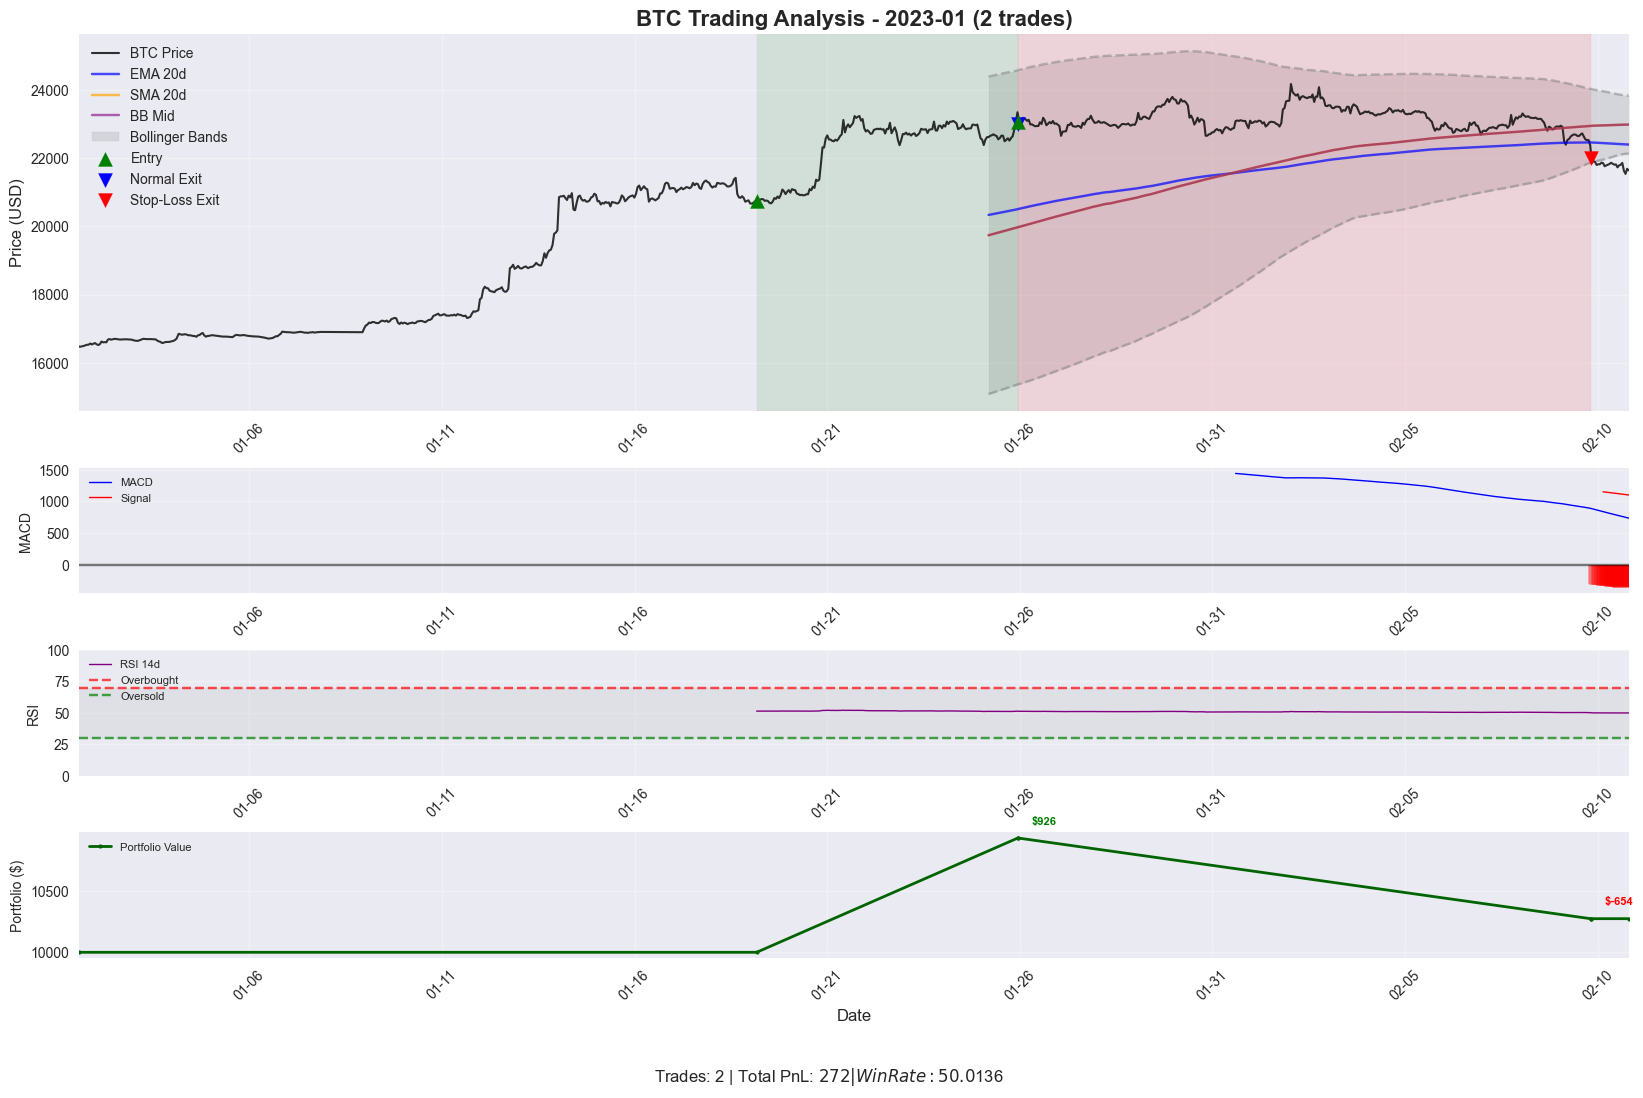


Processing 2023-02...


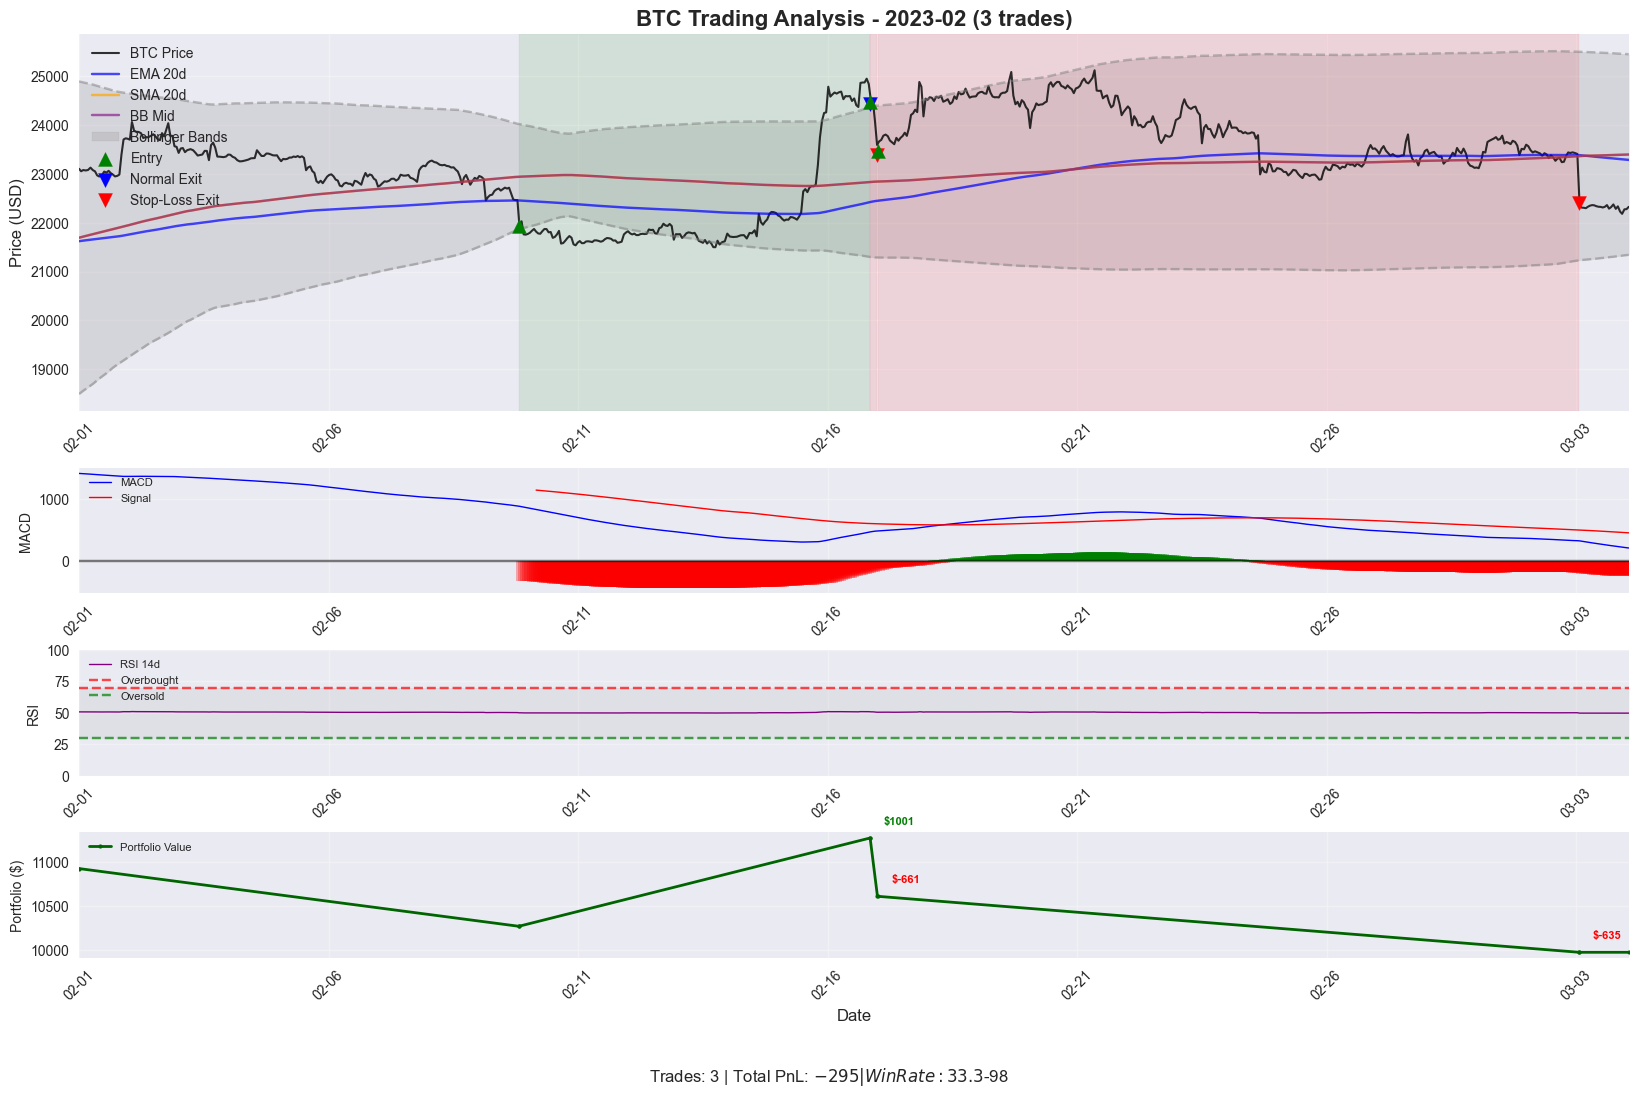


Processing 2023-03...


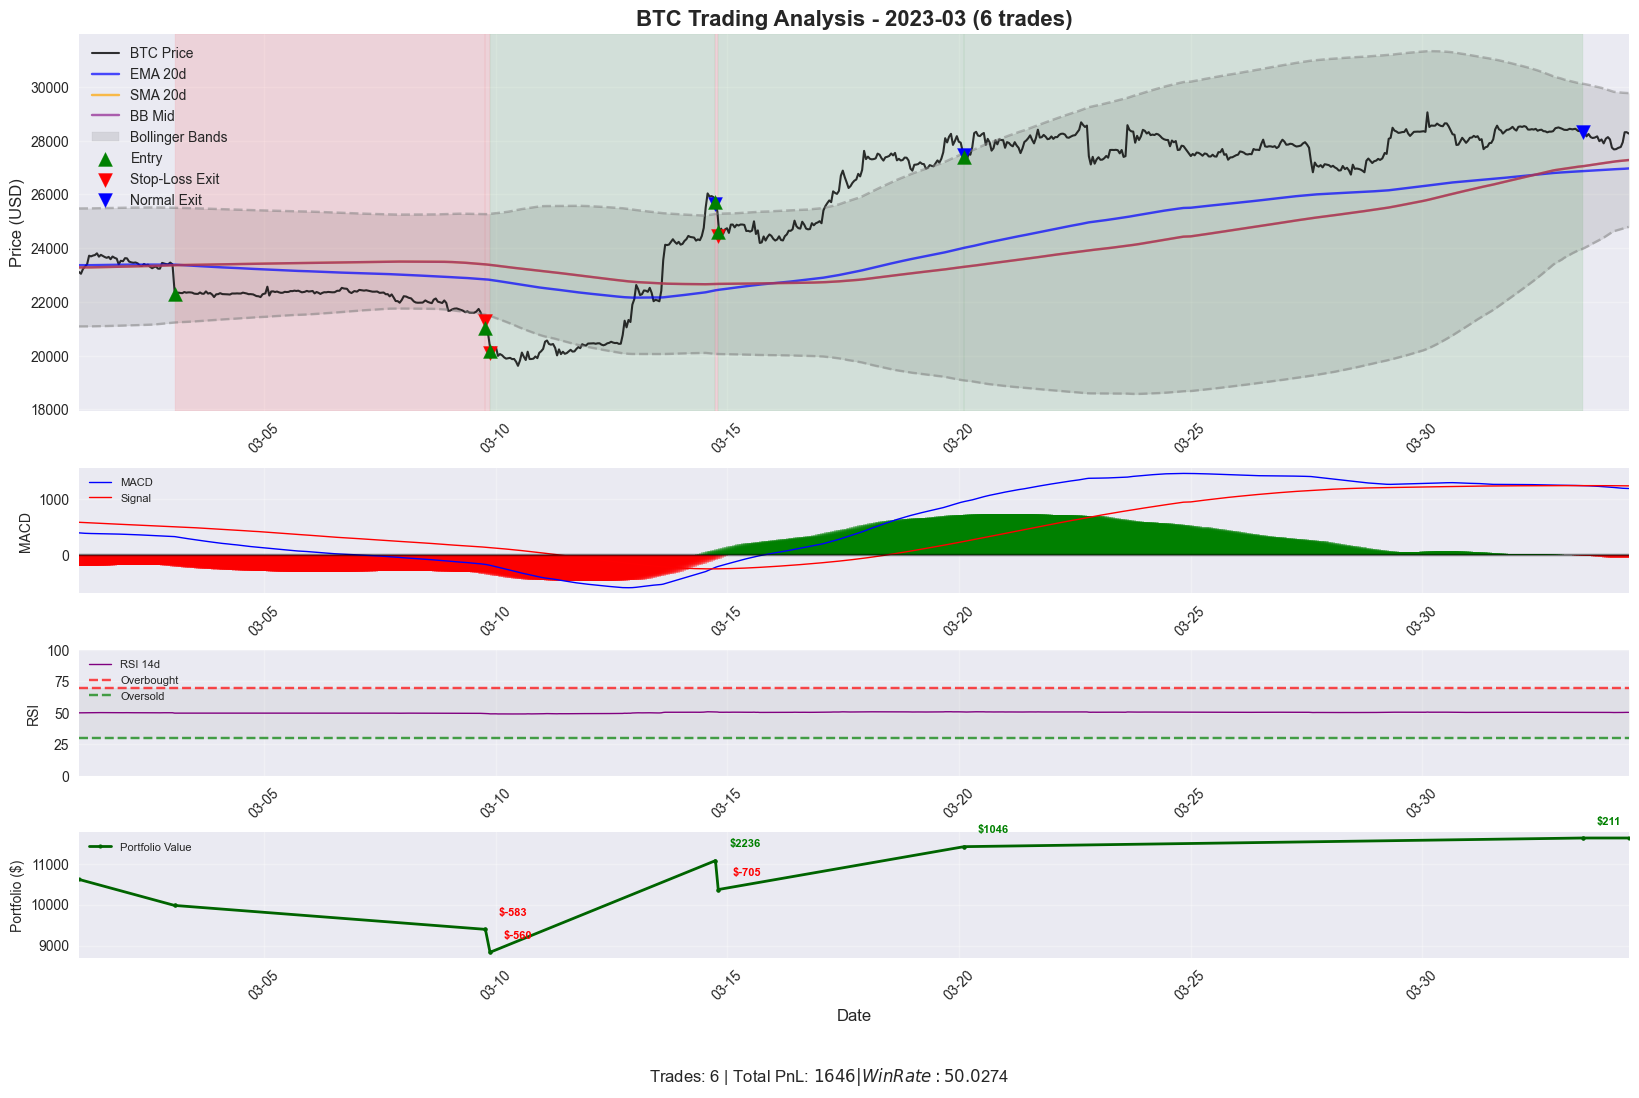


Processing 2023-04...


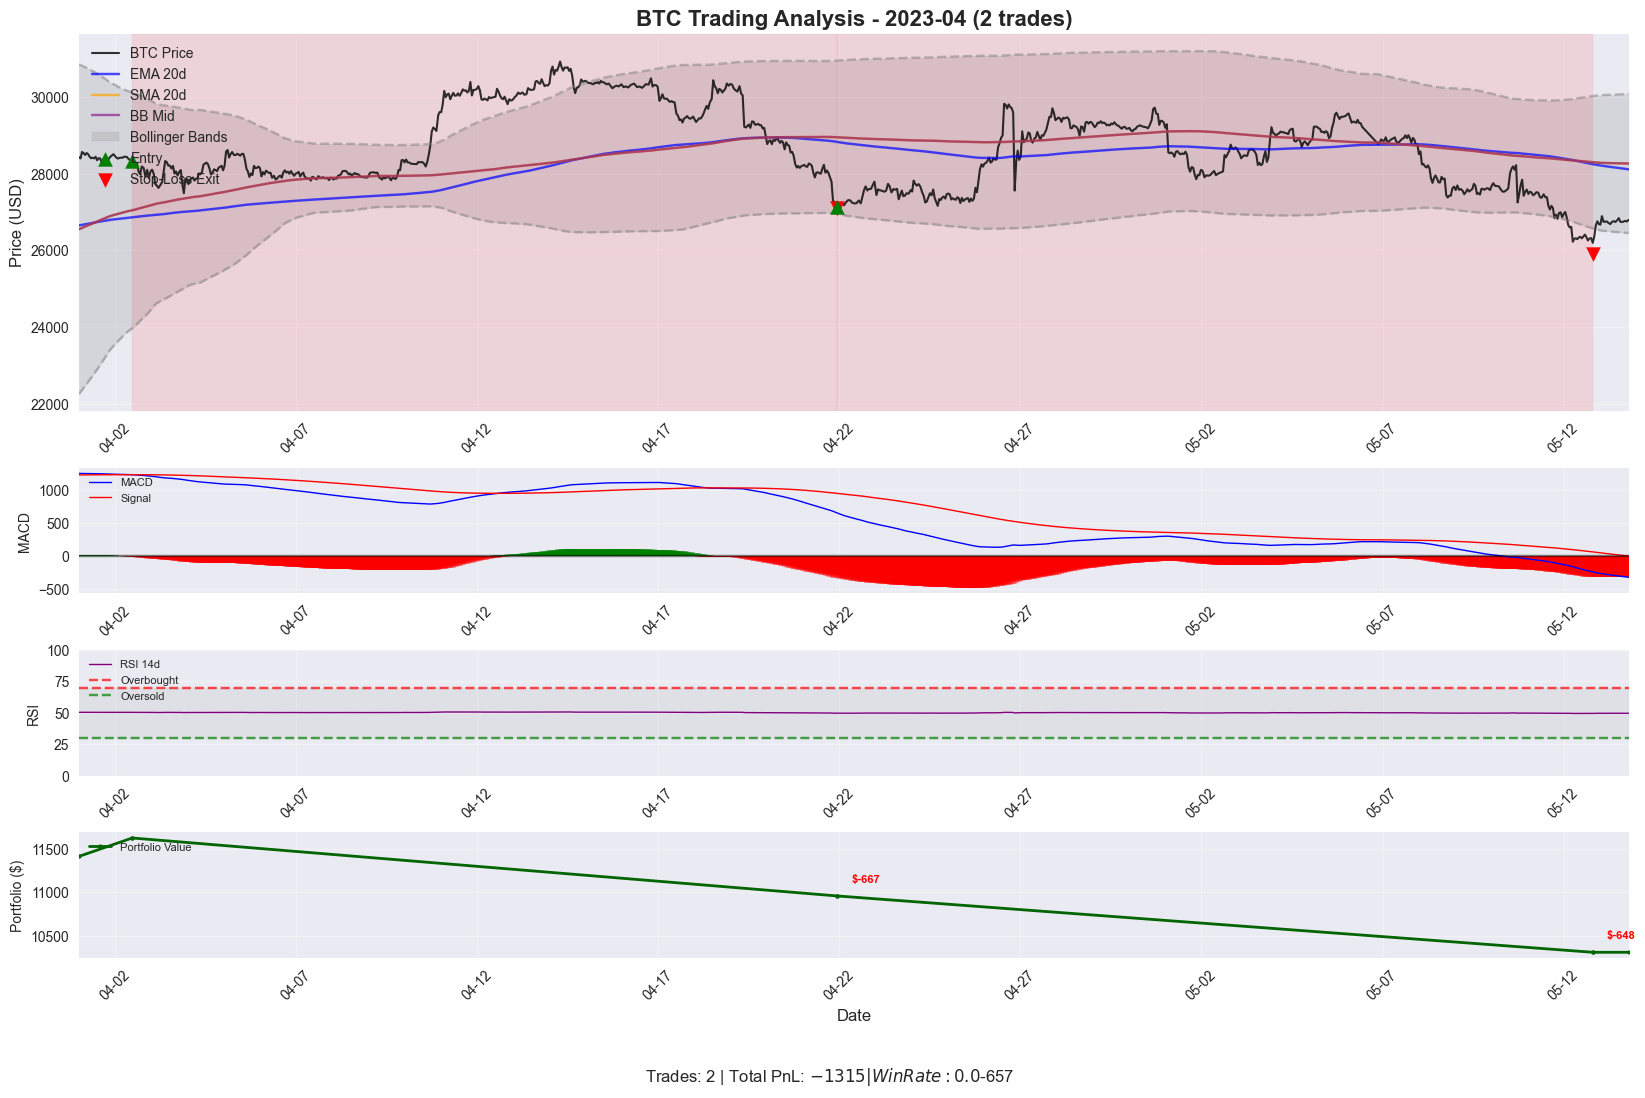


Processing 2023-05...


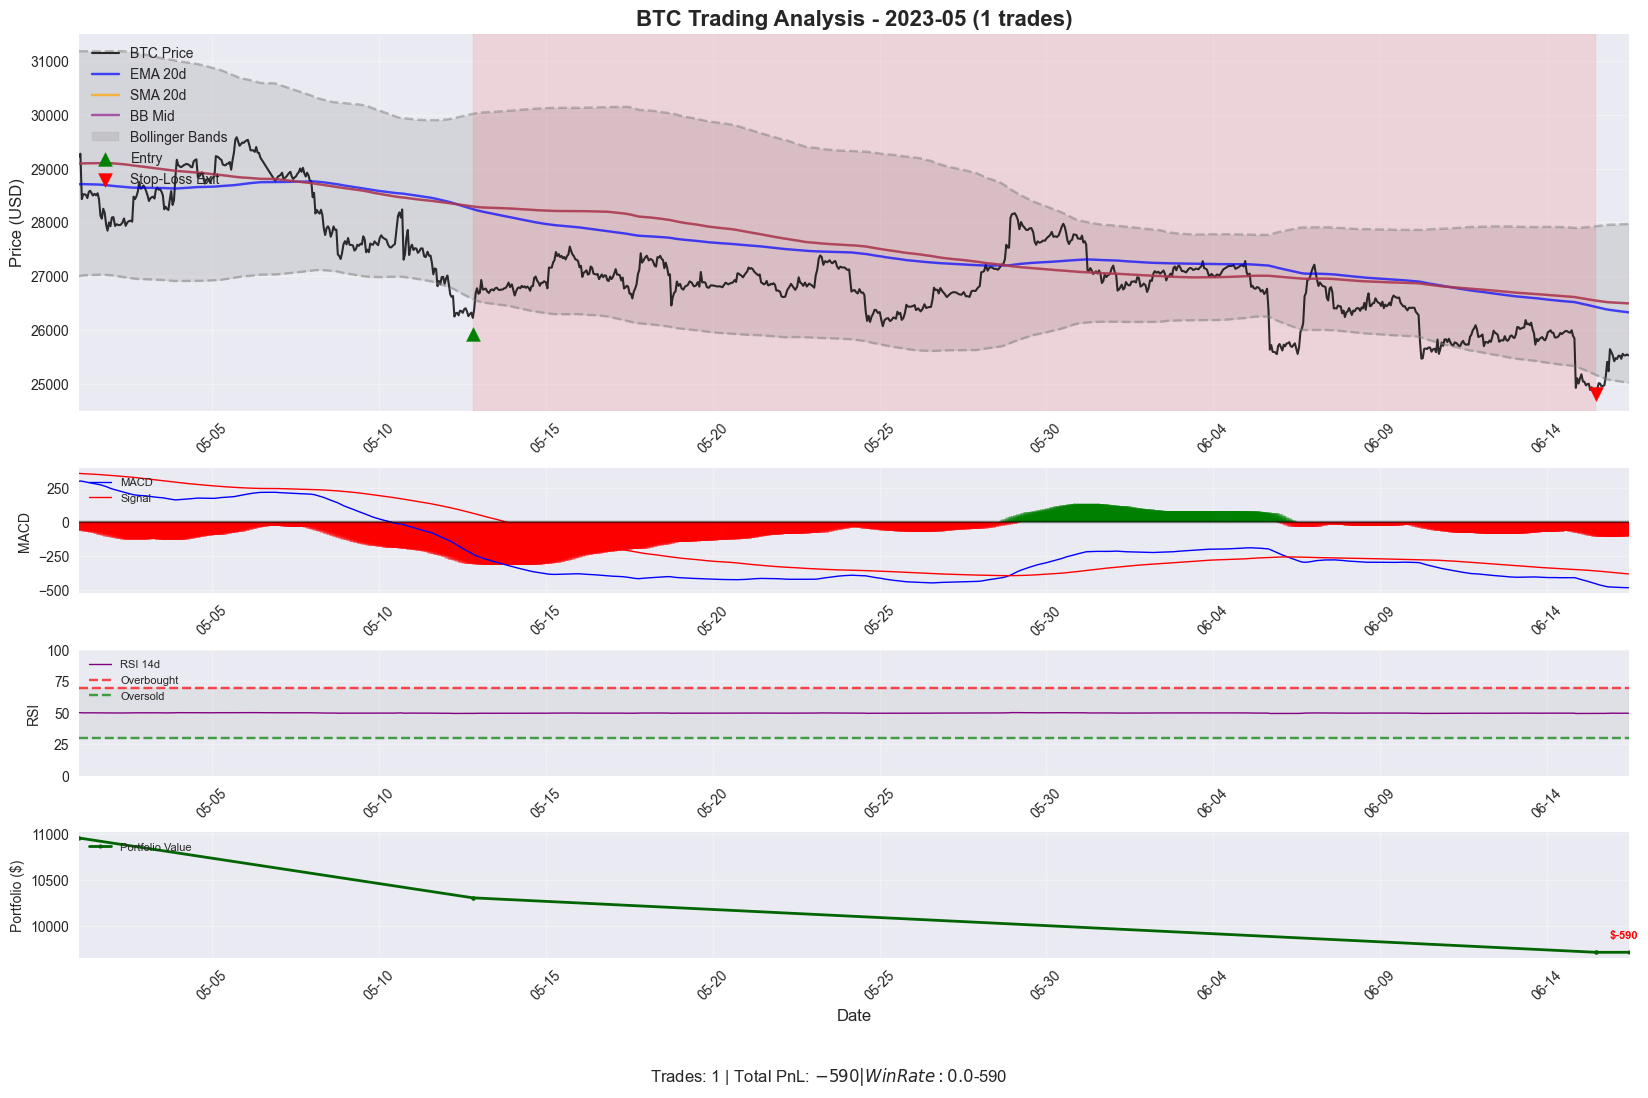


Processing 2023-06...


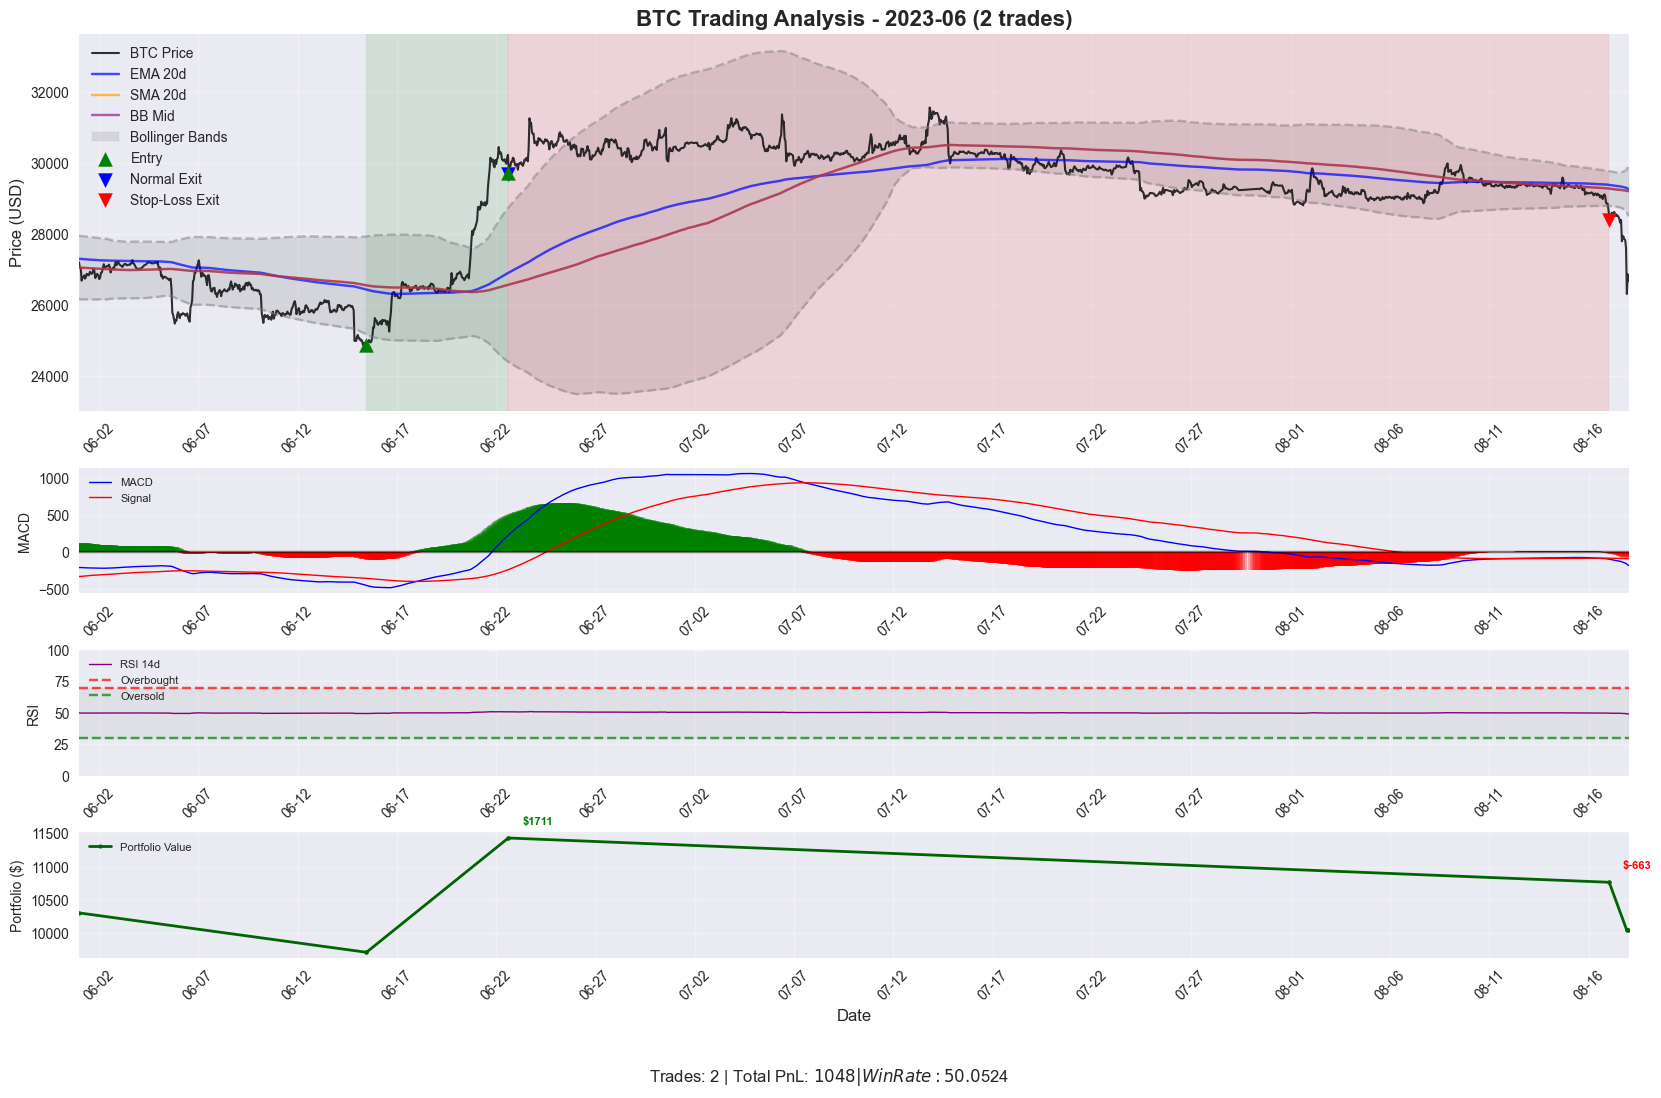


Processing 2023-07...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


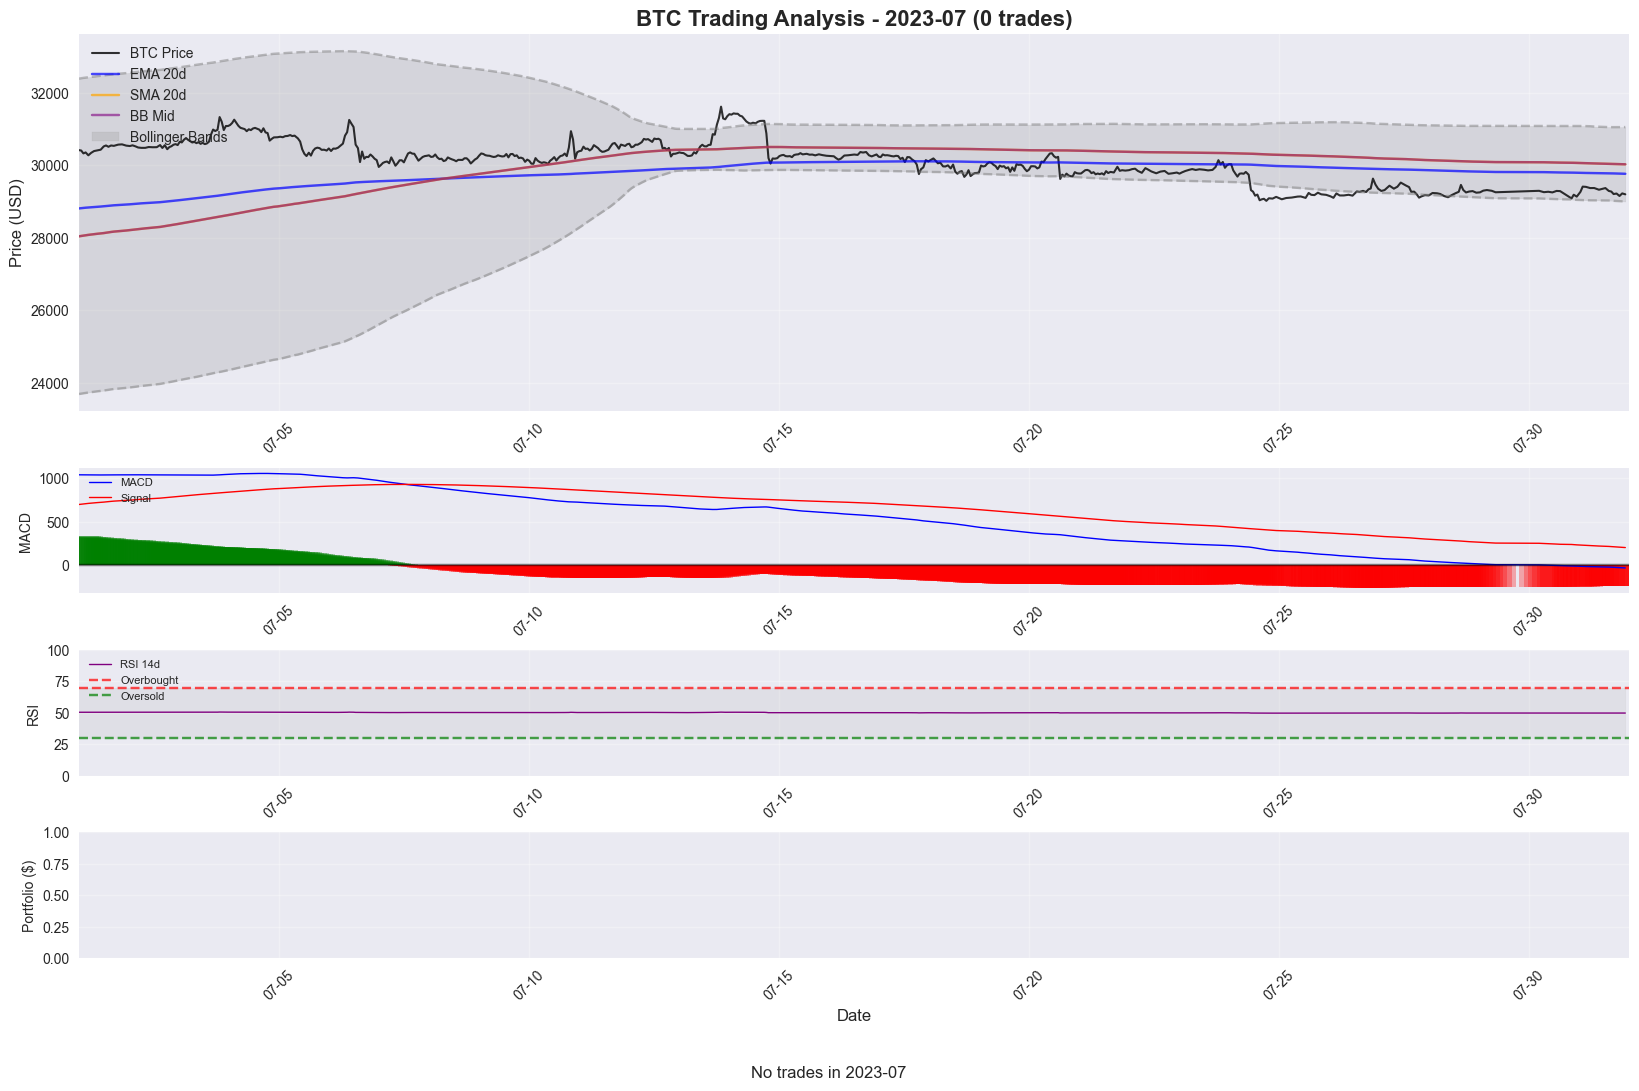


Processing 2023-08...


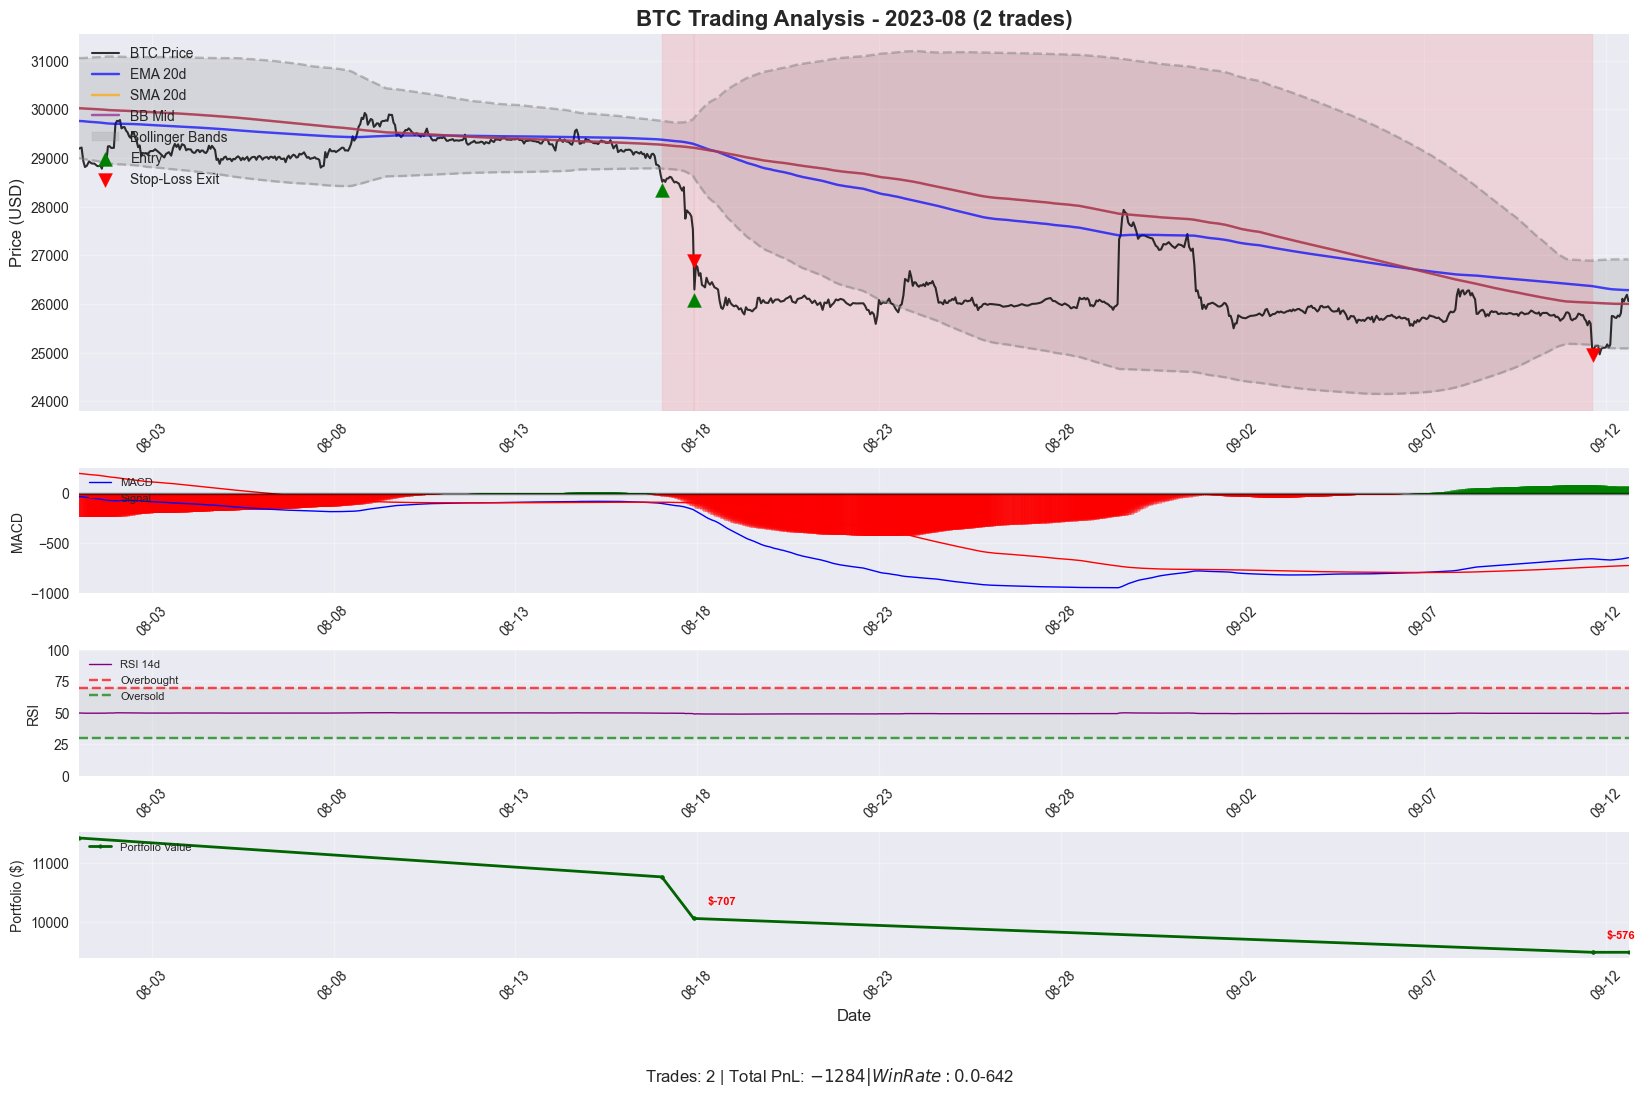


Processing 2023-09...


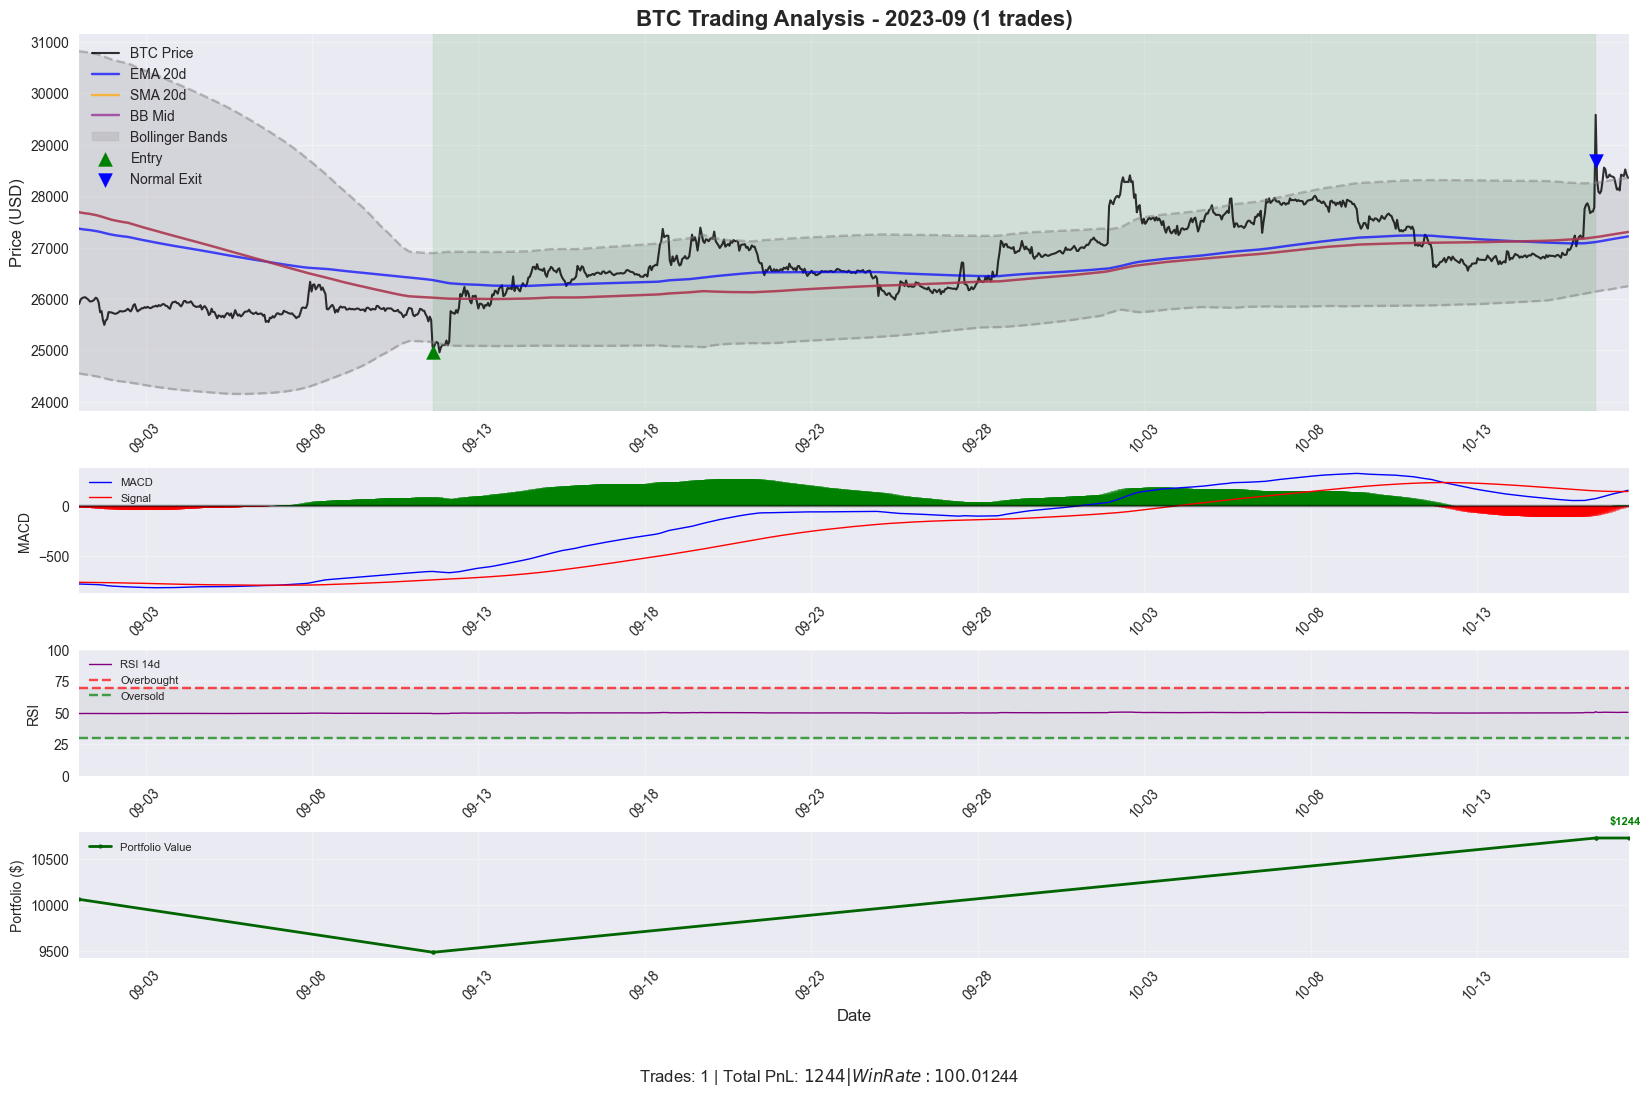


Processing 2023-10...


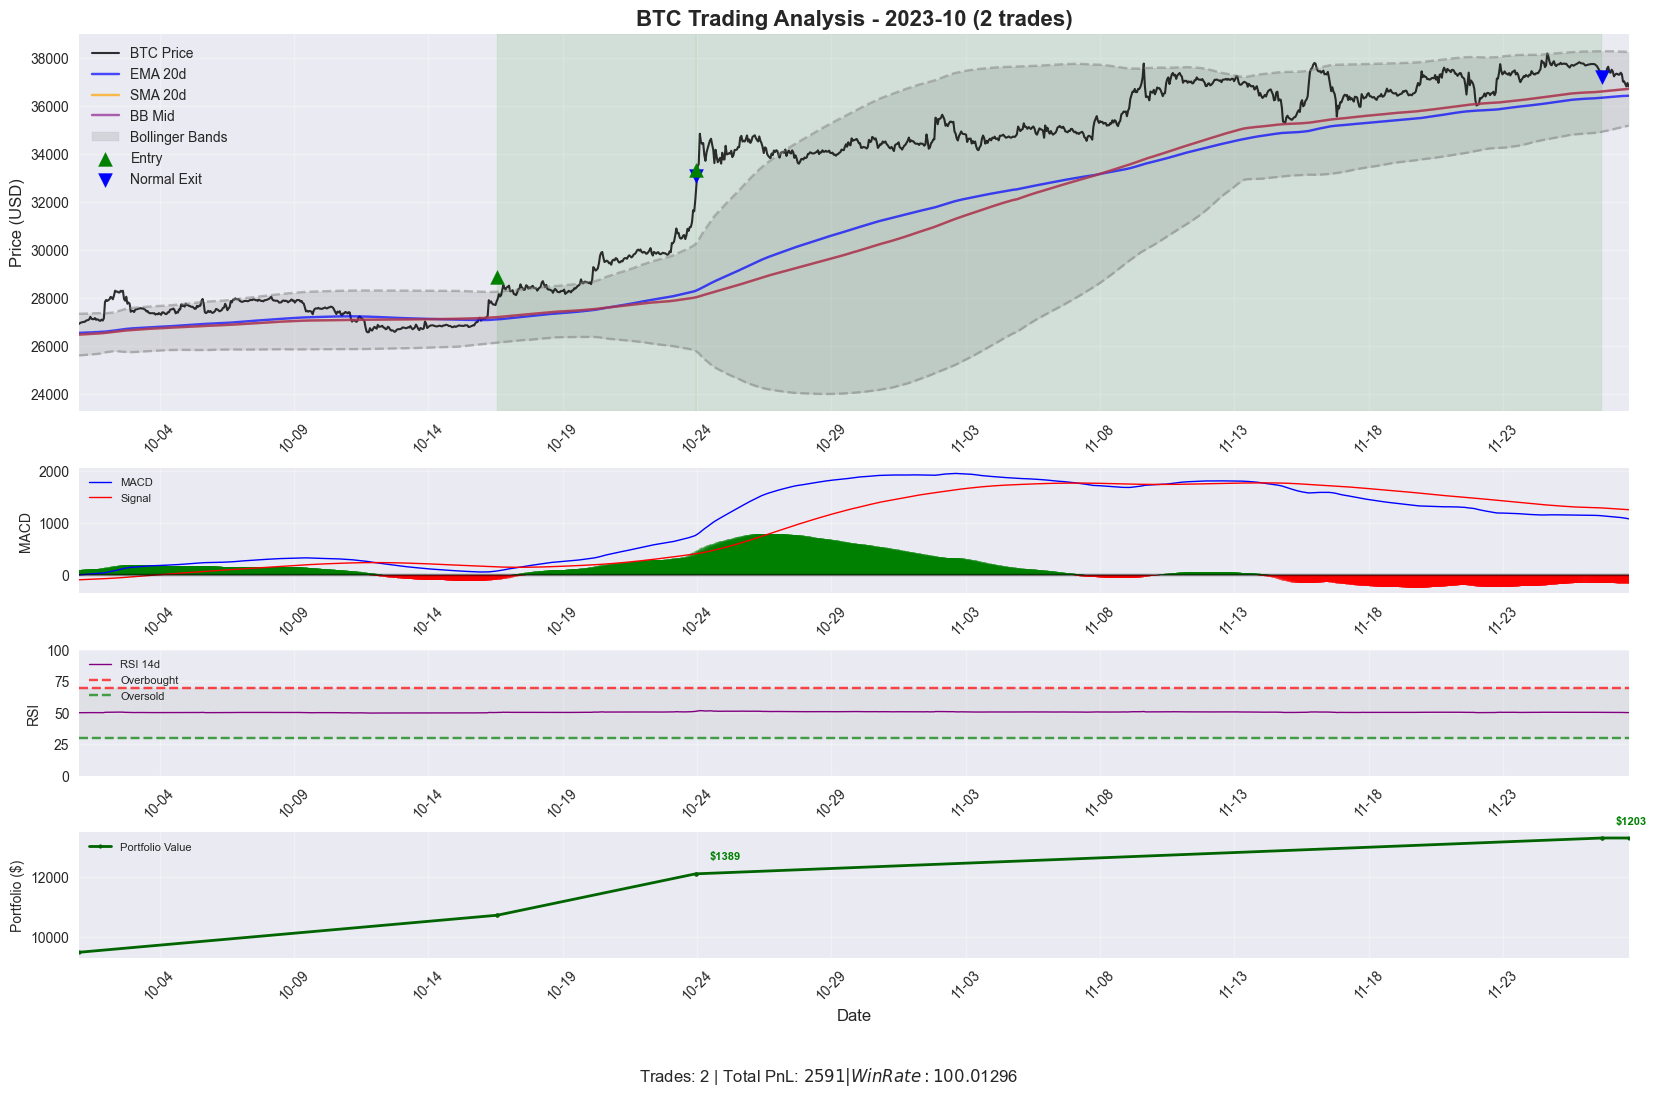


Processing 2023-11...


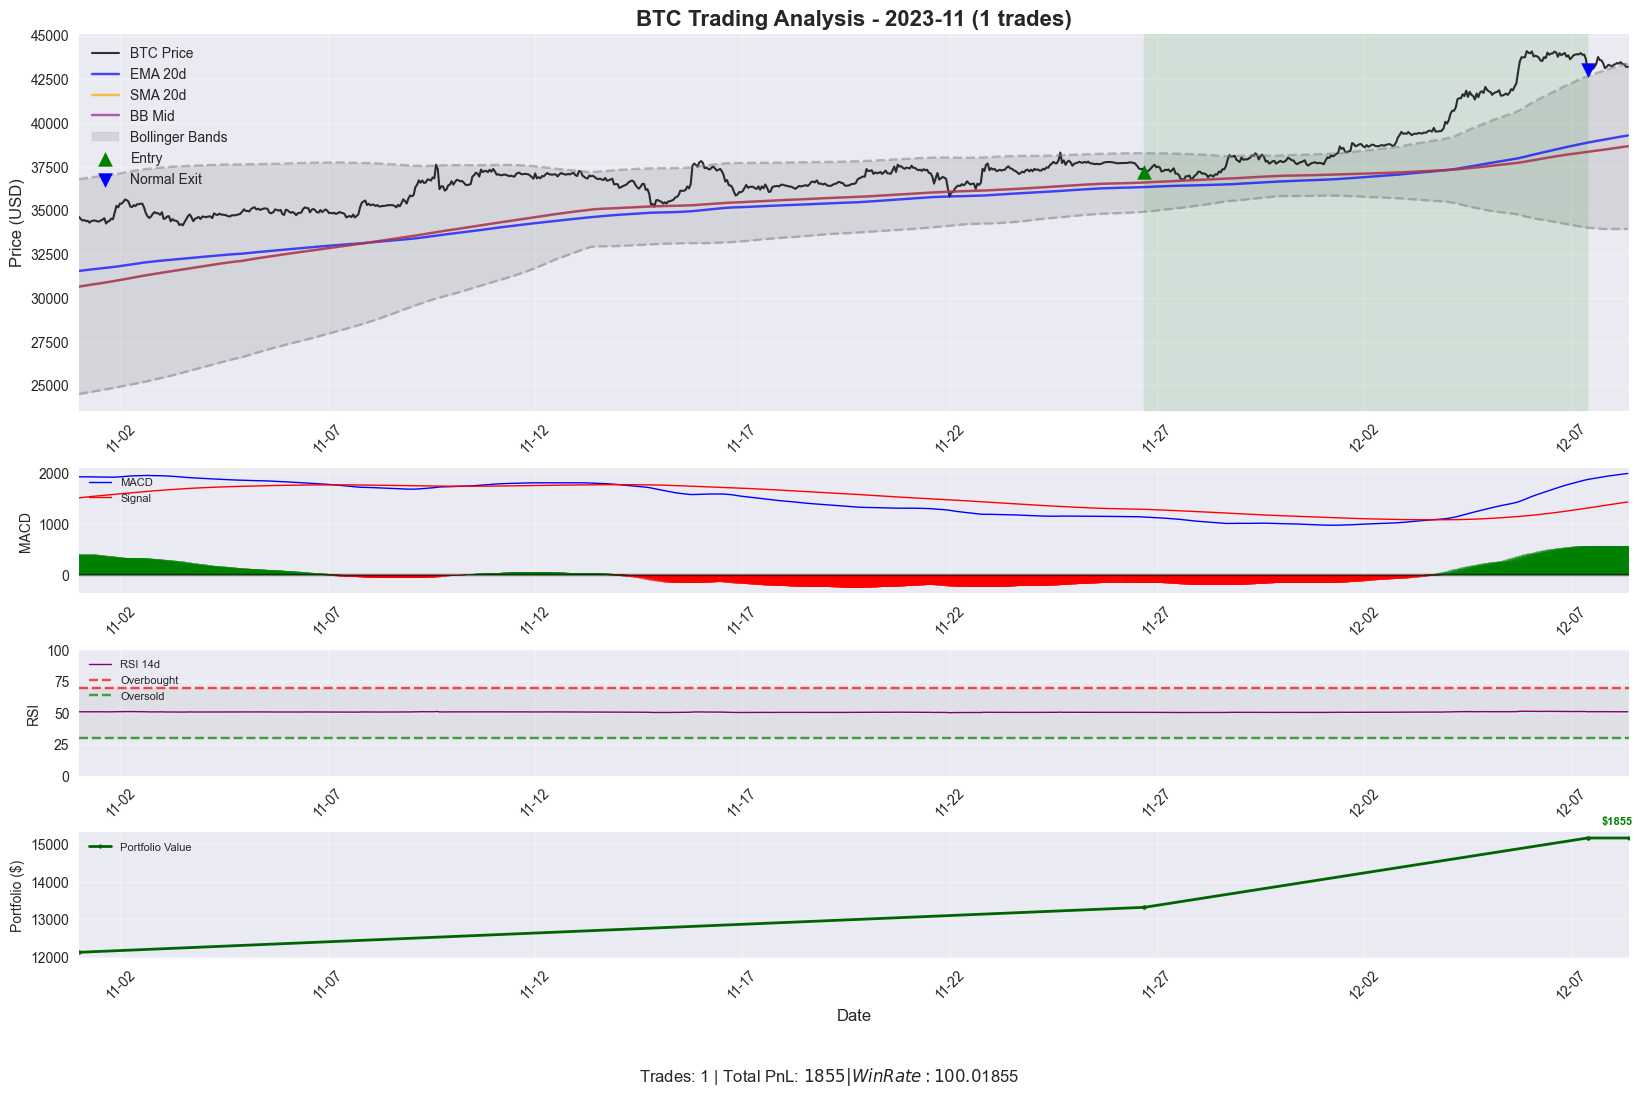


Processing 2023-12...


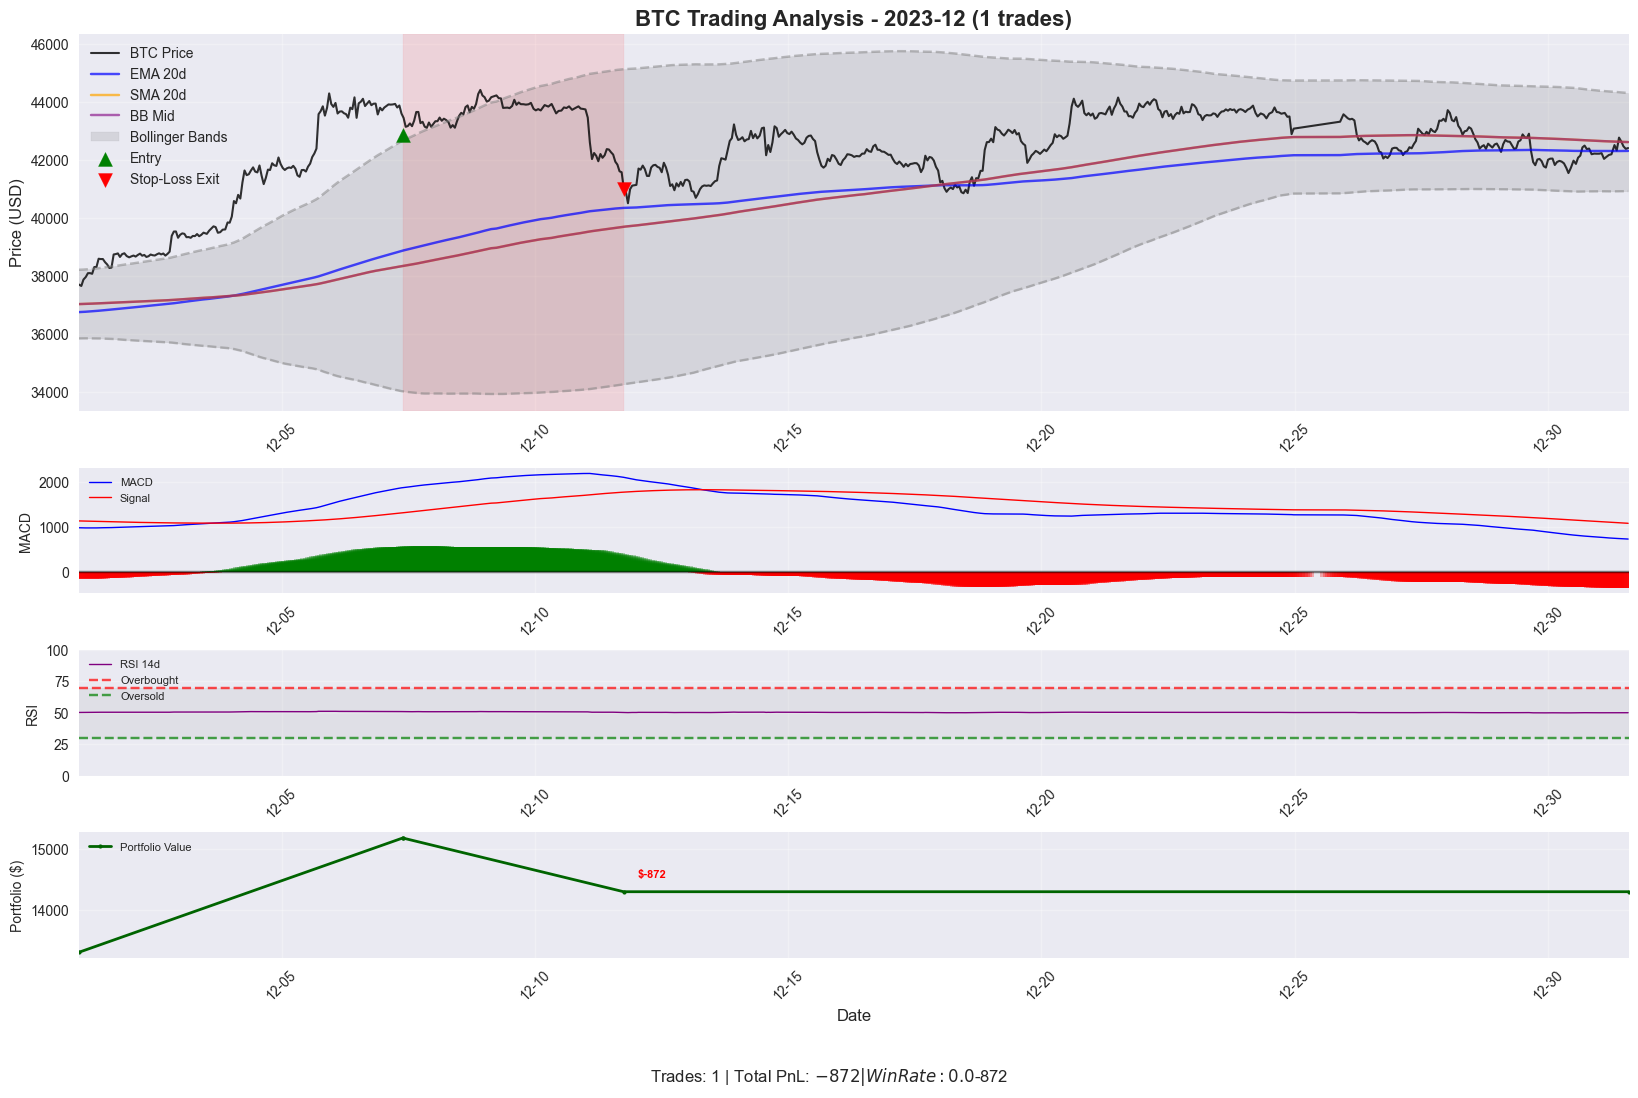

In [66]:
# Generate visualizations for all months in 2023
months = range(1, 13)
year = 2023

print("Generating monthly analysis charts...")
print("="*50)

for month in months:
    print(f"\nProcessing {year}-{month:02d}...")
    try:
        fig = plot_month_analysis(year, month, btc_data, trade_log, portfolio_df)
    except Exception as e:
        print(f"Error processing {year}-{month:02d}: {str(e)}")
        continue

In [67]:
# Summary statistics for the entire year
print("\n" + "="*60)
print("ANNUAL TRADING SUMMARY - 2023")
print("="*60)

total_trades = len(trade_log)
total_pnl = trade_log['PnL ($)'].sum()
win_rate = (trade_log['PnL ($)'] > 0).mean() * 100
avg_pnl = trade_log['PnL ($)'].mean()
best_trade = trade_log['PnL ($)'].max()
worst_trade = trade_log['PnL ($)'].min()
initial_value = 10000
final_value = trade_log['Exit Value ($)'].iloc[-1]
total_return = ((final_value - initial_value) / initial_value) * 100

print(f"Total Trades: {total_trades}")
print(f"Total PnL: ${total_pnl:.2f}")
print(f"Win Rate: {win_rate:.1f}%")
print(f"Average PnL per Trade: ${avg_pnl:.2f}")
print(f"Best Trade: ${best_trade:.2f}")
print(f"Worst Trade: ${worst_trade:.2f}")
print(f"Initial Portfolio: ${initial_value:.2f}")
print(f"Final Portfolio: ${final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")

# Monthly breakdown
print("\nMONTHLY BREAKDOWN:")
print("-" * 40)
for month in range(1, 13):
    month_trades = trade_log[
        (trade_log['Entry Time'].dt.month == month)
    ]
    if len(month_trades) > 0:
        month_pnl = month_trades['PnL ($)'].sum()
        month_trades_count = len(month_trades)
        month_win_rate = (month_trades['PnL ($)'] > 0).mean() * 100
        print(f"{year}-{month:02d}: {month_trades_count} trades, ${month_pnl:.0f} PnL, {month_win_rate:.1f}% win rate")
    else:
        print(f"{year}-{month:02d}: No trades")


ANNUAL TRADING SUMMARY - 2023
Total Trades: 23
Total PnL: $4301.41
Win Rate: 43.5%
Average PnL per Trade: $187.02
Best Trade: $2235.81
Worst Trade: $-872.16
Initial Portfolio: $10000.00
Final Portfolio: $14301.39
Total Return: 43.01%

MONTHLY BREAKDOWN:
----------------------------------------
2023-01: 2 trades, $272 PnL, 50.0% win rate
2023-02: 3 trades, $-295 PnL, 33.3% win rate
2023-03: 6 trades, $1646 PnL, 50.0% win rate
2023-04: 2 trades, $-1315 PnL, 0.0% win rate
2023-05: 1 trades, $-590 PnL, 0.0% win rate
2023-06: 2 trades, $1048 PnL, 50.0% win rate
2023-07: No trades
2023-08: 2 trades, $-1284 PnL, 0.0% win rate
2023-09: 1 trades, $1244 PnL, 100.0% win rate
2023-10: 2 trades, $2591 PnL, 100.0% win rate
2023-11: 1 trades, $1855 PnL, 100.0% win rate
2023-12: 1 trades, $-872 PnL, 0.0% win rate


---
# Fee-Aware ML Model Analysis

This section analyzes the fee-aware ML model trading performance using the ML dataset with additional indicators including EMA/SMA 7d.

In [68]:
# Load ML dataset and fee-aware trade logs
import glob
import os

# Load ML dataset
ml_btc_data = pd.read_csv('../data/BTCUSD_2023-1min_ML.csv')
ml_btc_data['Timestamp'] = pd.to_datetime(ml_btc_data['Timestamp'])
ml_btc_data.set_index('Timestamp', inplace=True)

# Load all fee-aware trade logs
trade_logs_path = '../models/trade_logs/'
fee_aware_files = glob.glob(os.path.join(trade_logs_path, 'trade_log_*_fee_aware.csv'))

fee_aware_trade_logs = {}
for file_path in fee_aware_files:
    model_name = os.path.basename(file_path).replace('trade_log_', '').replace('_fee_aware.csv', '')
    df = pd.read_csv(file_path)
    df['Entry Time'] = pd.to_datetime(df['Entry Time'])
    df['Exit Time'] = pd.to_datetime(df['Exit Time'])
    fee_aware_trade_logs[model_name] = df

print(f"ML BTC Data shape: {ml_btc_data.shape}")
print(f"Date range: {ml_btc_data.index.min()} to {ml_btc_data.index.max()}")
print(f"\nLoaded {len(fee_aware_trade_logs)} fee-aware trade logs:")
for model_name, df in fee_aware_trade_logs.items():
    print(f"  {model_name}: {len(df)} trades")

# Show columns in ML dataset
print(f"\nML Dataset columns: {list(ml_btc_data.columns)}")

ML BTC Data shape: (484640, 25)
Date range: 2023-01-01 14:00:00 to 2023-12-31 14:27:00

Loaded 5 fee-aware trade logs:
  DecisionTreeClassifier: 73 trades
  ExtraTreesClassifier: 65 trades
  KNeighborsClassifier: 58 trades
  LGBMClassifier: 52 trades
  RandomForestClassifier: 65 trades

ML Dataset columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']


In [69]:
def plot_fee_aware_month_analysis(year, month, btc_data, trade_log, model_name):
    """
    Create comprehensive monthly analysis plot for fee-aware trading
    """
    # Filter data for the month - convert to pandas datetime
    start_date = pd.to_datetime(f"{year}-{month:02d}-01")
    if month == 12:
        end_date = pd.to_datetime(f"{year+1}-01-01")
    else:
        end_date = pd.to_datetime(f"{year}-{month+1:02d}-01")
    
    # Get trades for this month (entries in this month)
    monthly_trades = trade_log[
        (trade_log['Entry Time'] >= start_date) & 
        (trade_log['Entry Time'] < end_date)
    ]
    
    # Extend date range to include any ongoing trades from this month
    extended_end_date = end_date
    if len(monthly_trades) > 0:
        latest_exit = monthly_trades['Exit Time'].max()
        if latest_exit >= end_date:
            # Extend to include the exit time plus a small buffer
            extended_end_date = latest_exit + pd.Timedelta(days=1)
    
    # Filter BTC data using datetime objects
    monthly_btc = btc_data[(btc_data.index >= start_date) & (btc_data.index < extended_end_date)]
    
    if len(monthly_btc) == 0:
        print(f"No data available for {year}-{month:02d}")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(4, 1, height_ratios=[3, 1, 1, 1], hspace=0.3)
    
    # Main price chart
    ax1 = fig.add_subplot(gs[0])
    
    # Sample data for visualization (every 60 minutes to reduce clutter)
    sample_data = monthly_btc.iloc[::60]  # Every hour
    
    # Plot price and indicators
    ax1.plot(sample_data.index, sample_data['Close'], label='BTC Price', color='black', linewidth=1.5, alpha=0.8)
    
    # Technical indicators with ML dataset columns
    if 'ema_20d' in sample_data.columns:
        ax1.plot(sample_data.index, sample_data['ema_20d'], label='EMA 20d', color='blue', alpha=0.7)
    if 'ema_7d' in sample_data.columns:
        ax1.plot(sample_data.index, sample_data['ema_7d'], label='EMA 7d', color='lightblue', alpha=0.7)
    if 'sma_20d' in sample_data.columns:
        ax1.plot(sample_data.index, sample_data['sma_20d'], label='SMA 20d', color='orange', alpha=0.7)
    if 'sma_7d' in sample_data.columns:
        ax1.plot(sample_data.index, sample_data['sma_7d'], label='SMA 7d', color='yellow', alpha=0.7)
    if 'bb_mid_20d' in sample_data.columns:
        ax1.plot(sample_data.index, sample_data['bb_mid_20d'], label='BB Mid', color='purple', alpha=0.6)
    if 'bb_upper_20d' in sample_data.columns and 'bb_lower_20d' in sample_data.columns:
        ax1.fill_between(sample_data.index, sample_data['bb_upper_20d'], sample_data['bb_lower_20d'], 
                        alpha=0.2, color='gray', label='Bollinger Bands')
        ax1.plot(sample_data.index, sample_data['bb_upper_20d'], color='gray', alpha=0.5, linestyle='--')
        ax1.plot(sample_data.index, sample_data['bb_lower_20d'], color='gray', alpha=0.5, linestyle='--')
    
    # Plot trade entries and exits with fee awareness
    entry_plotted = False
    normal_exit_plotted = False
    sl_exit_plotted = False
    fee_aware_exit_plotted = False
    
    for idx, trade in monthly_trades.iterrows():
        # Entry points
        ax1.scatter(trade['Entry Time'], trade['Entry Price'], color='green', s=100, marker='^', 
                   label='Entry' if not entry_plotted else '', zorder=5)
        entry_plotted = True
        
        # Exit points - different colors for different exit types
        exit_type = str(trade['Exit Type'])
        if 'Stop-Loss' in exit_type:
            exit_color = 'red'
            exit_label = 'Stop-Loss Exit' if not sl_exit_plotted else ''
            sl_exit_plotted = True
        elif 'Fee-Aware' in exit_type:
            exit_color = 'orange'
            exit_label = 'Fee-Aware Exit' if not fee_aware_exit_plotted else ''
            fee_aware_exit_plotted = True
        else:
            exit_color = 'blue'
            exit_label = 'Normal Exit' if not normal_exit_plotted else ''
            normal_exit_plotted = True
            
        ax1.scatter(trade['Exit Time'], trade['Exit Price'], color=exit_color, s=100, marker='v', 
                   label=exit_label, zorder=5)
        
        # Add trade duration shading
        ax1.axvspan(trade['Entry Time'], trade['Exit Time'], alpha=0.1, 
                   color='green' if trade['PnL ($)'] > 0 else 'red')
    
    ax1.set_title(f'{model_name} Fee-Aware Trading Analysis - {year}-{month:02d} ({len(monthly_trades)} trades)', 
                  fontsize=16, fontweight='bold')
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # MACD subplot
    ax2 = fig.add_subplot(gs[1])
    if 'macd_12_26' in sample_data.columns and 'macd_sig_12_26' in sample_data.columns:
        ax2.plot(sample_data.index, sample_data['macd_12_26'], label='MACD', color='blue', linewidth=1)
        ax2.plot(sample_data.index, sample_data['macd_sig_12_26'], label='Signal', color='red', linewidth=1)
        
        # MACD histogram
        if 'macd_hist_12_26' in sample_data.columns:
            colors = ['green' if x >= 0 else 'red' for x in sample_data['macd_hist_12_26']]
            ax2.bar(sample_data.index, sample_data['macd_hist_12_26'], color=colors, alpha=0.3, width=0.8)
    
    ax2.set_ylabel('MACD', fontsize=10)
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # RSI subplot
    ax3 = fig.add_subplot(gs[2])
    if 'rsi_14d' in sample_data.columns:
        ax3.plot(sample_data.index, sample_data['rsi_14d'], label='RSI 14d', color='purple', linewidth=1)
        ax3.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought')
        ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold')
        ax3.fill_between(sample_data.index, 30, 70, alpha=0.1, color='gray')
    
    ax3.set_ylabel('RSI', fontsize=10)
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # Portfolio value subplot with fee information - FIXED: Aligned timeline
    ax4 = fig.add_subplot(gs[3])
    
    # Create a continuous portfolio value line aligned with the main chart
    if len(monthly_trades) > 0:
        # Get the date range that matches the main chart
        chart_start = monthly_btc.index.min()
        chart_end = monthly_btc.index.max()
        
        # Create portfolio timeline that covers the entire chart period
        portfolio_timeline = []
        current_value = 10000  # Starting portfolio value
        
        # Find the portfolio value at the start of the chart period
        # Look for any trades before this month to get the correct starting value
        pre_month_trades = trade_log[trade_log['Exit Time'] < chart_start]
        if len(pre_month_trades) > 0:
            current_value = pre_month_trades['Exit Value ($)'].iloc[-1]
        
        # Add point at chart start
        portfolio_timeline.append({
            'timestamp': chart_start,
            'value': current_value
        })
        
        # Add all trade entry and exit events within the chart period
        for idx, trade in monthly_trades.iterrows():
            # Entry point (portfolio value doesn't change at entry, just showing the point)
            portfolio_timeline.append({
                'timestamp': trade['Entry Time'],
                'value': current_value
            })
            
            # Exit point (portfolio value changes)
            current_value = trade['Exit Value ($)']
            portfolio_timeline.append({
                'timestamp': trade['Exit Time'],
                'value': current_value
            })
        
        # Add point at chart end with the last known value
        portfolio_timeline.append({
            'timestamp': chart_end,
            'value': current_value
        })
        
        # Convert to DataFrame and plot
        if len(portfolio_timeline) > 1:
            portfolio_chart_df = pd.DataFrame(portfolio_timeline)
            portfolio_chart_df = portfolio_chart_df.drop_duplicates(subset=['timestamp']).sort_values('timestamp')
            
            ax4.plot(portfolio_chart_df['timestamp'], portfolio_chart_df['value'], 
                    label='Portfolio Value', color='darkgreen', linewidth=2, marker='o', markersize=3)
        
        # Show trade PnL with fee information
        for idx, trade in monthly_trades.iterrows():
            color = 'green' if trade['PnL ($)'] > 0 else 'red'
            fee_total = trade['Entry Fees ($)'] + trade['Exit Fees ($)']
            ax4.annotate(f"${trade['PnL ($)']:.0f}\n(Fee: ${fee_total:.0f})", 
                        xy=(trade['Exit Time'], trade['Exit Value ($)']),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=7, color=color, fontweight='bold')
    
    ax4.set_ylabel('Portfolio ($)', fontsize=10)
    ax4.set_xlabel('Date', fontsize=12)
    ax4.legend(loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    # Format x-axis for all subplots to ensure alignment
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim(monthly_btc.index.min(), monthly_btc.index.max())  # Ensure same x-axis range
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Add summary statistics with fee information
    if len(monthly_trades) > 0:
        total_pnl = monthly_trades['PnL ($)'].sum()
        total_fees = (monthly_trades['Entry Fees ($)'] + monthly_trades['Exit Fees ($)']).sum()
        win_rate = (monthly_trades['PnL ($)'] > 0).mean() * 100
        avg_pnl = monthly_trades['PnL ($)'].mean()
        fee_aware_exits = len(monthly_trades[monthly_trades['Exit Type'].str.contains('Fee-Aware', na=False)])
        
        summary_text = f"Trades: {len(monthly_trades)} | Total PnL: ${total_pnl:.0f} | Fees: ${total_fees:.0f} | Win Rate: {win_rate:.1f}% | Fee-Aware Exits: {fee_aware_exits}"
        fig.suptitle(summary_text, fontsize=12, y=0.02)
    else:
        fig.suptitle(f"No trades in {year}-{month:02d}", fontsize=12, y=0.02)
    
    plt.tight_layout()
    plt.show()
    
    return fig

Analyzing KNeighborsClassifier Fee-Aware Trading Performance

Generating KNeighborsClassifier fee-aware monthly analysis charts...

Processing KNeighborsClassifier 2023-01...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


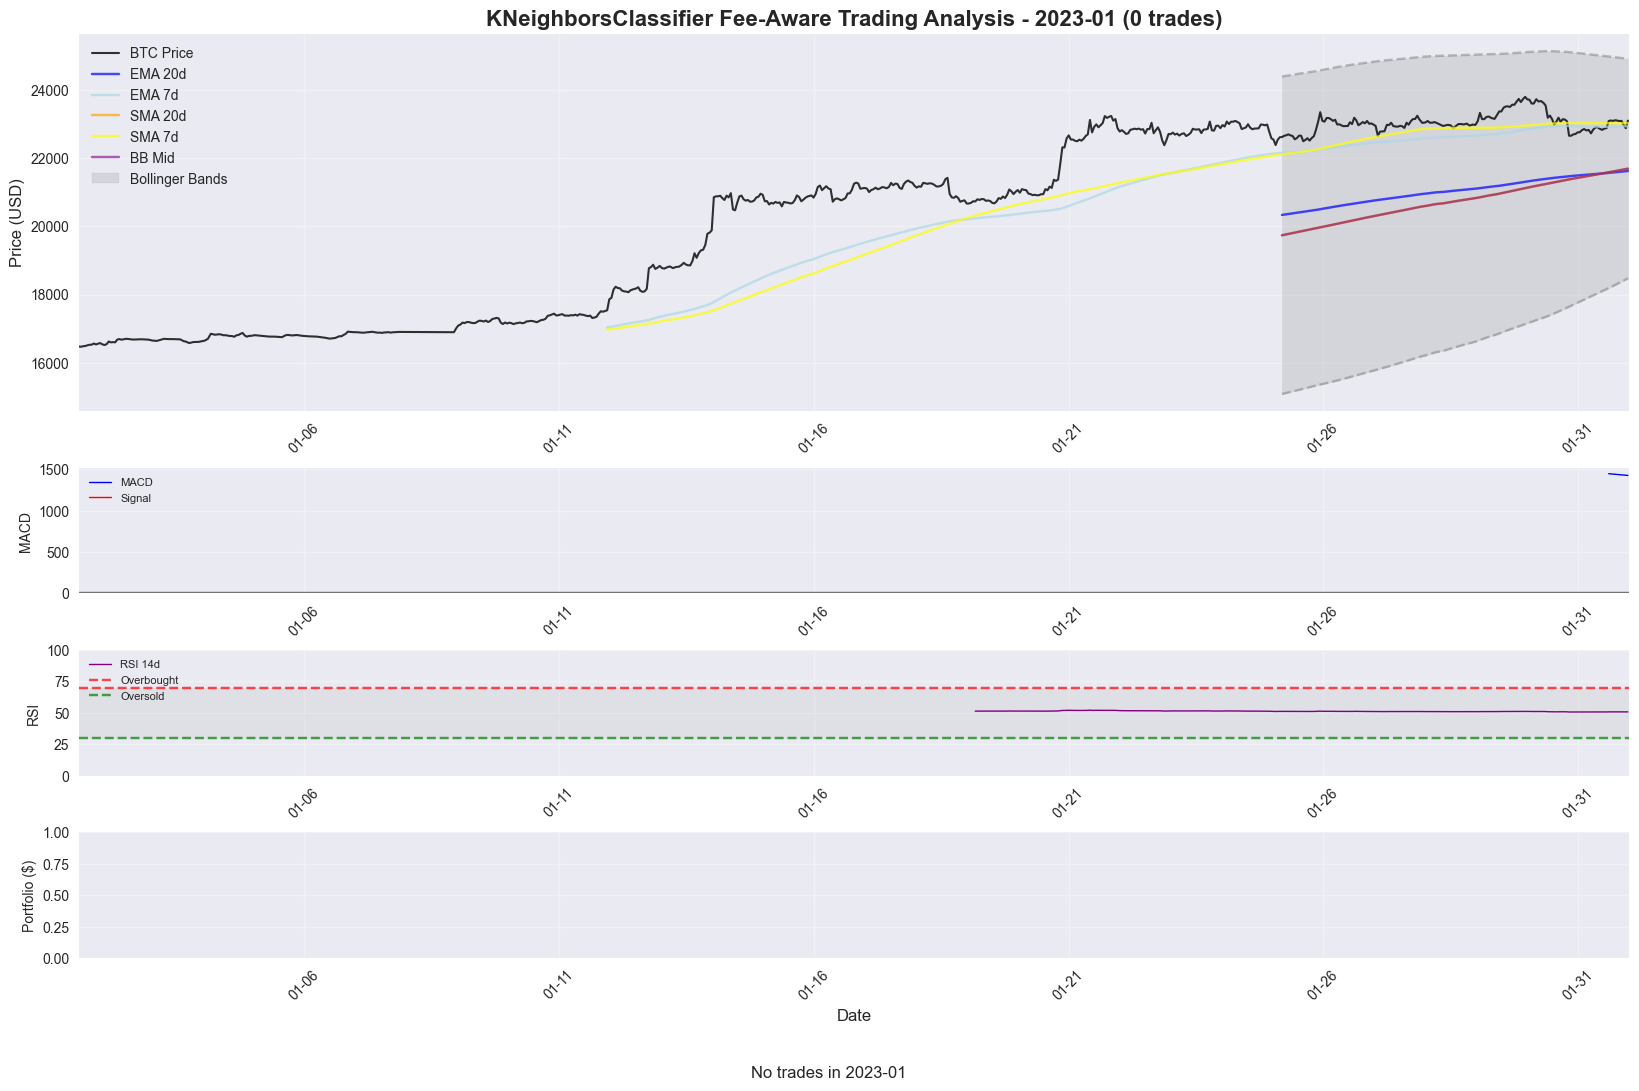


Processing KNeighborsClassifier 2023-02...


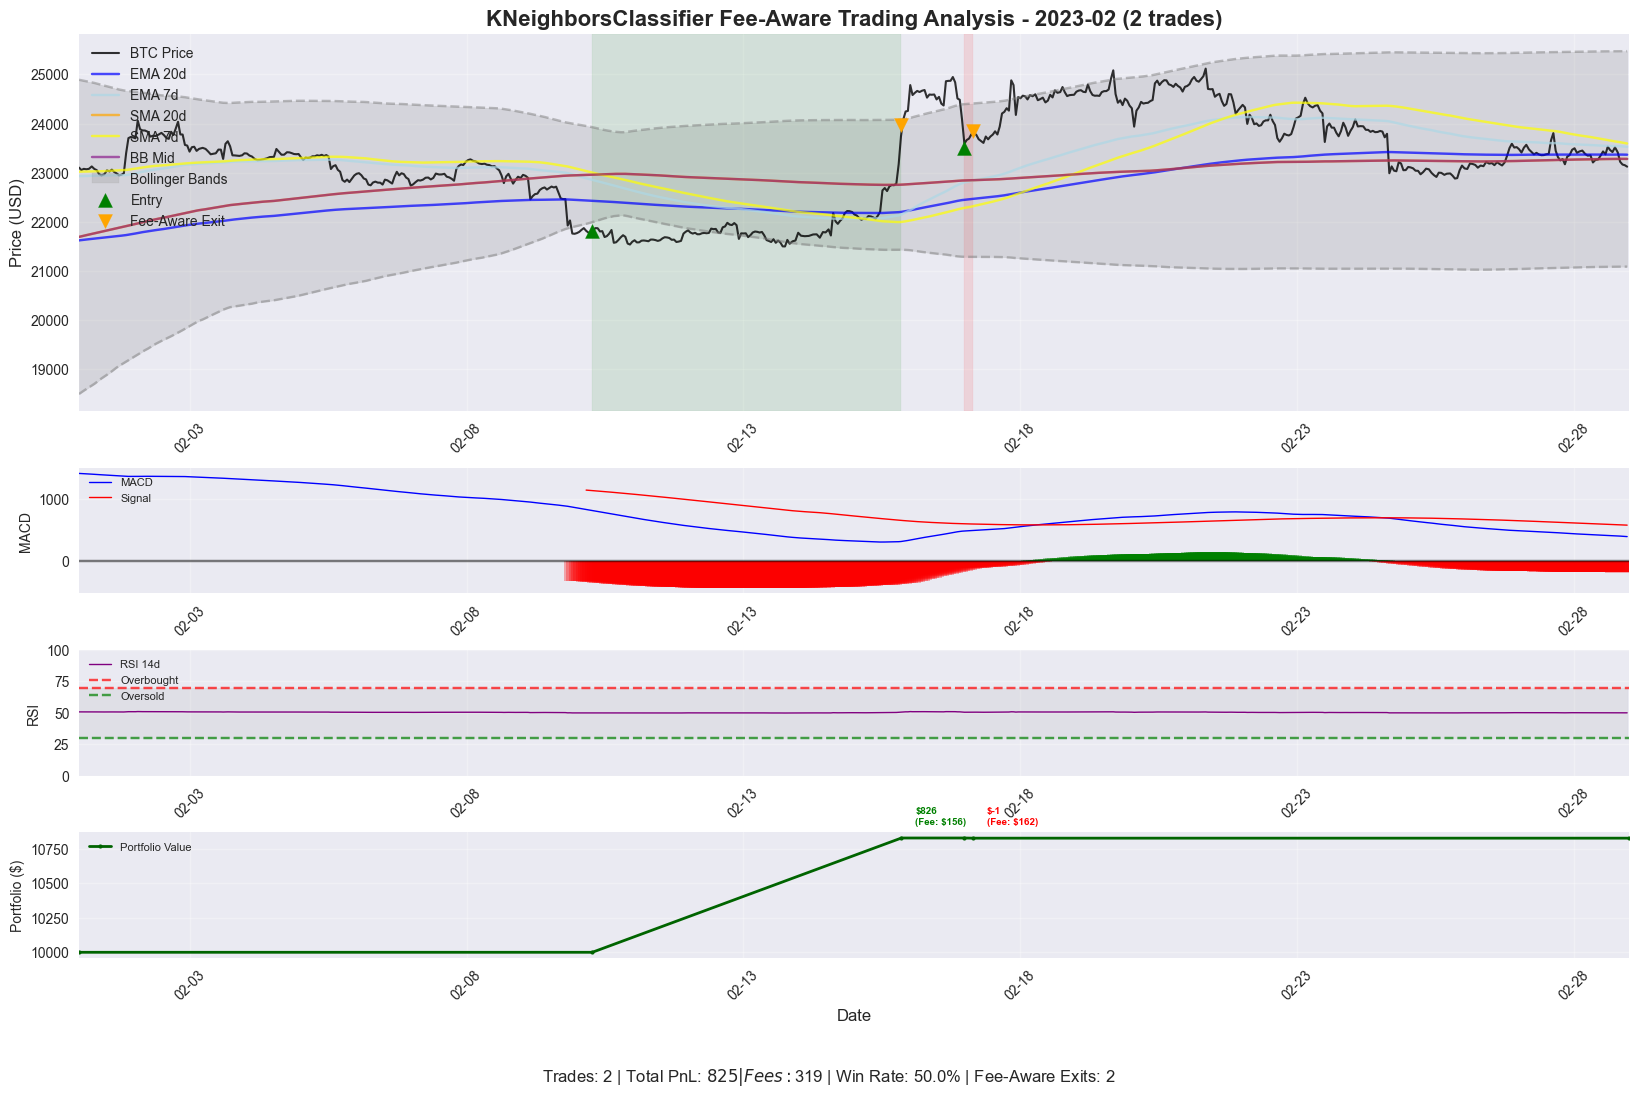


Processing KNeighborsClassifier 2023-03...


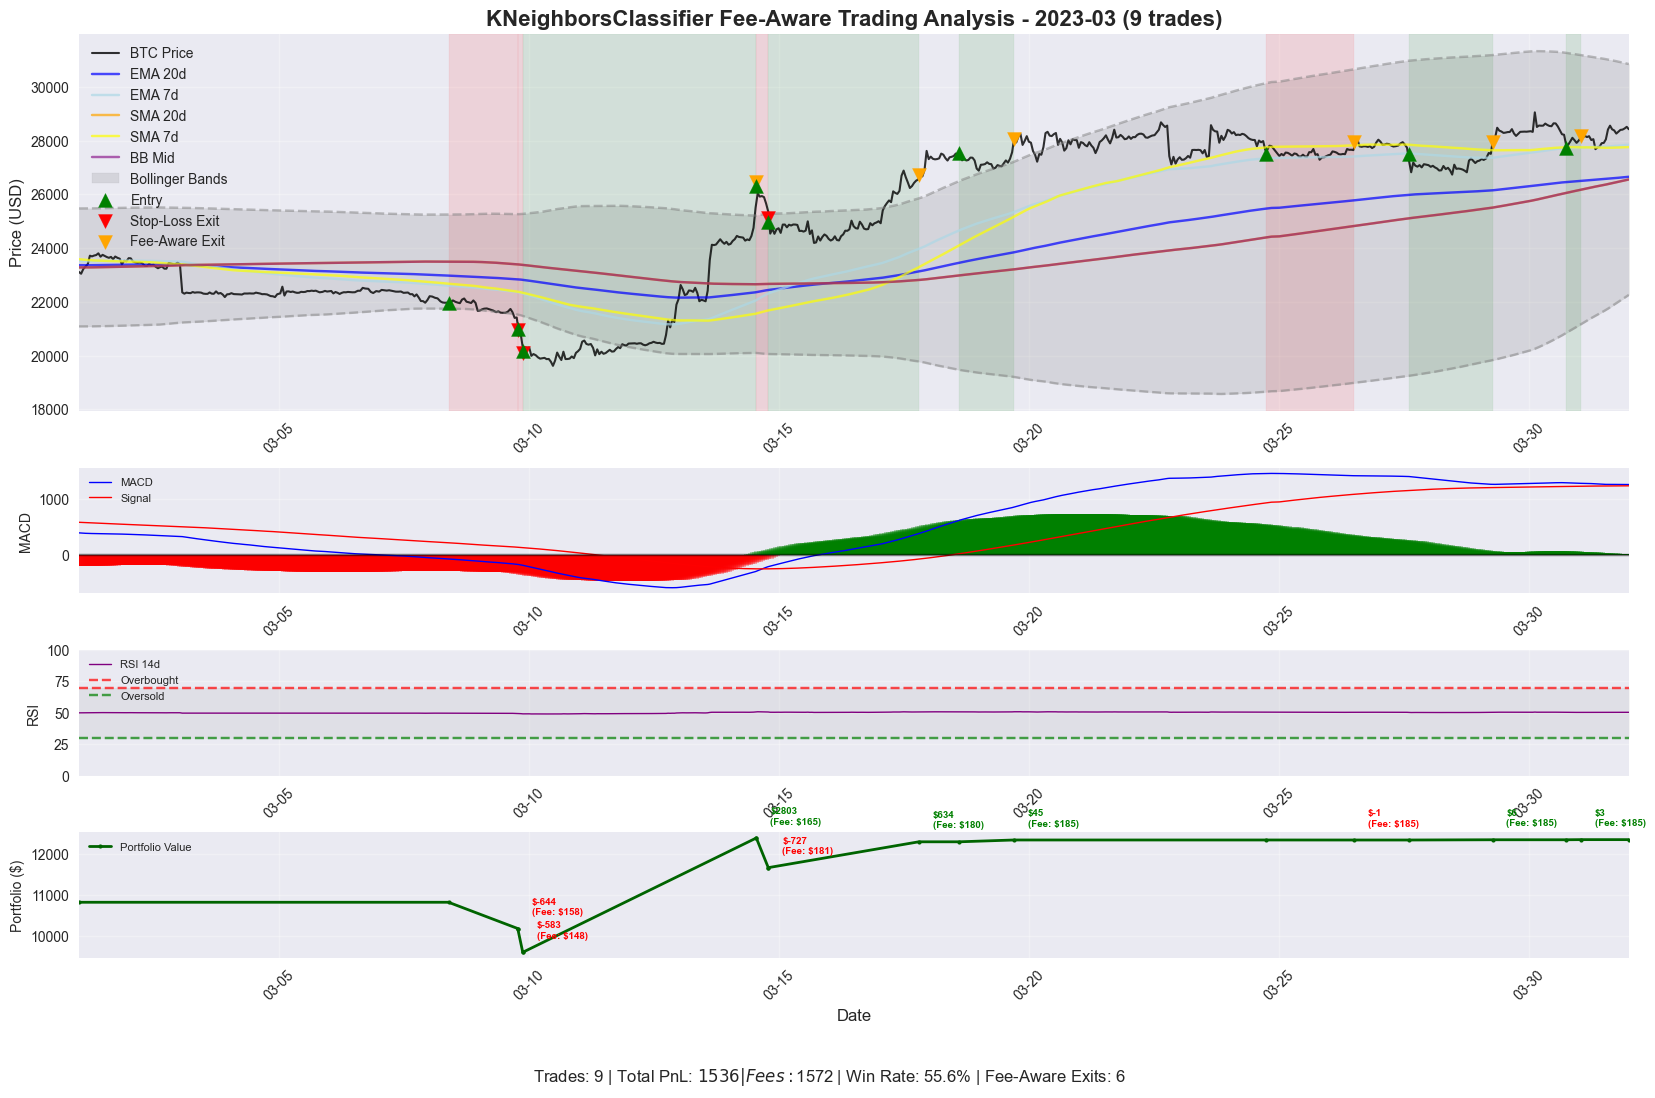


Processing KNeighborsClassifier 2023-04...


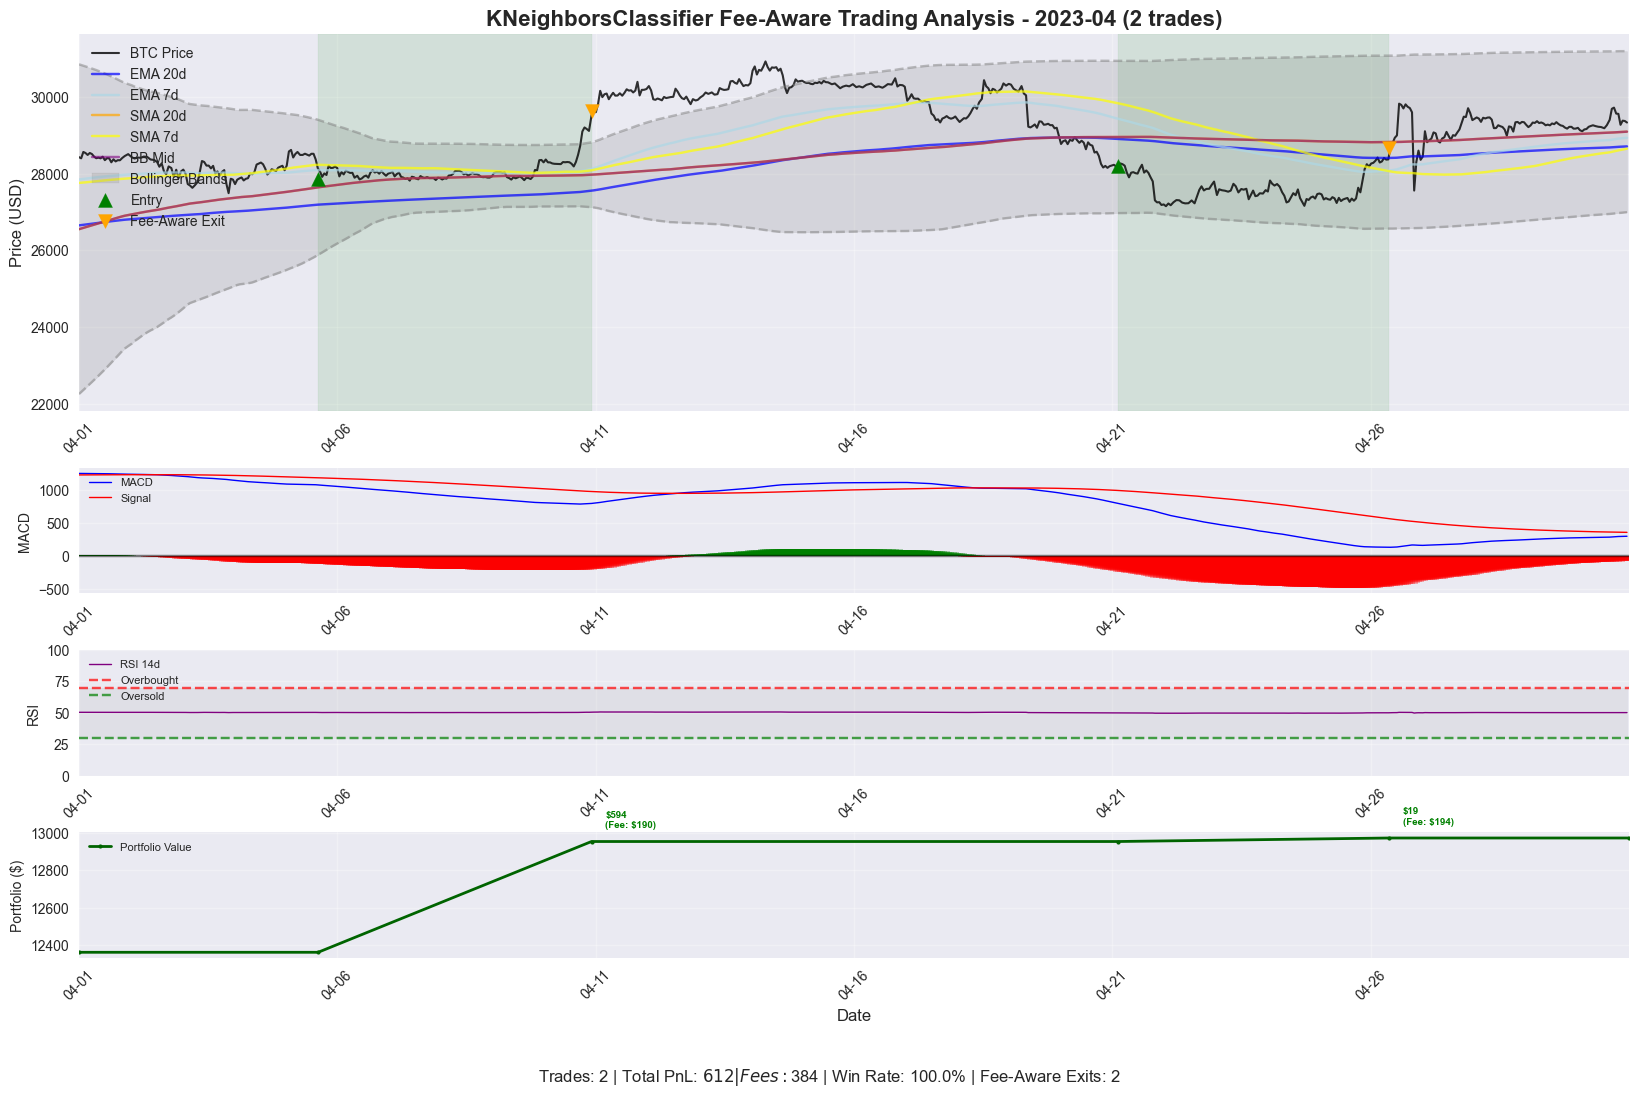


Processing KNeighborsClassifier 2023-05...


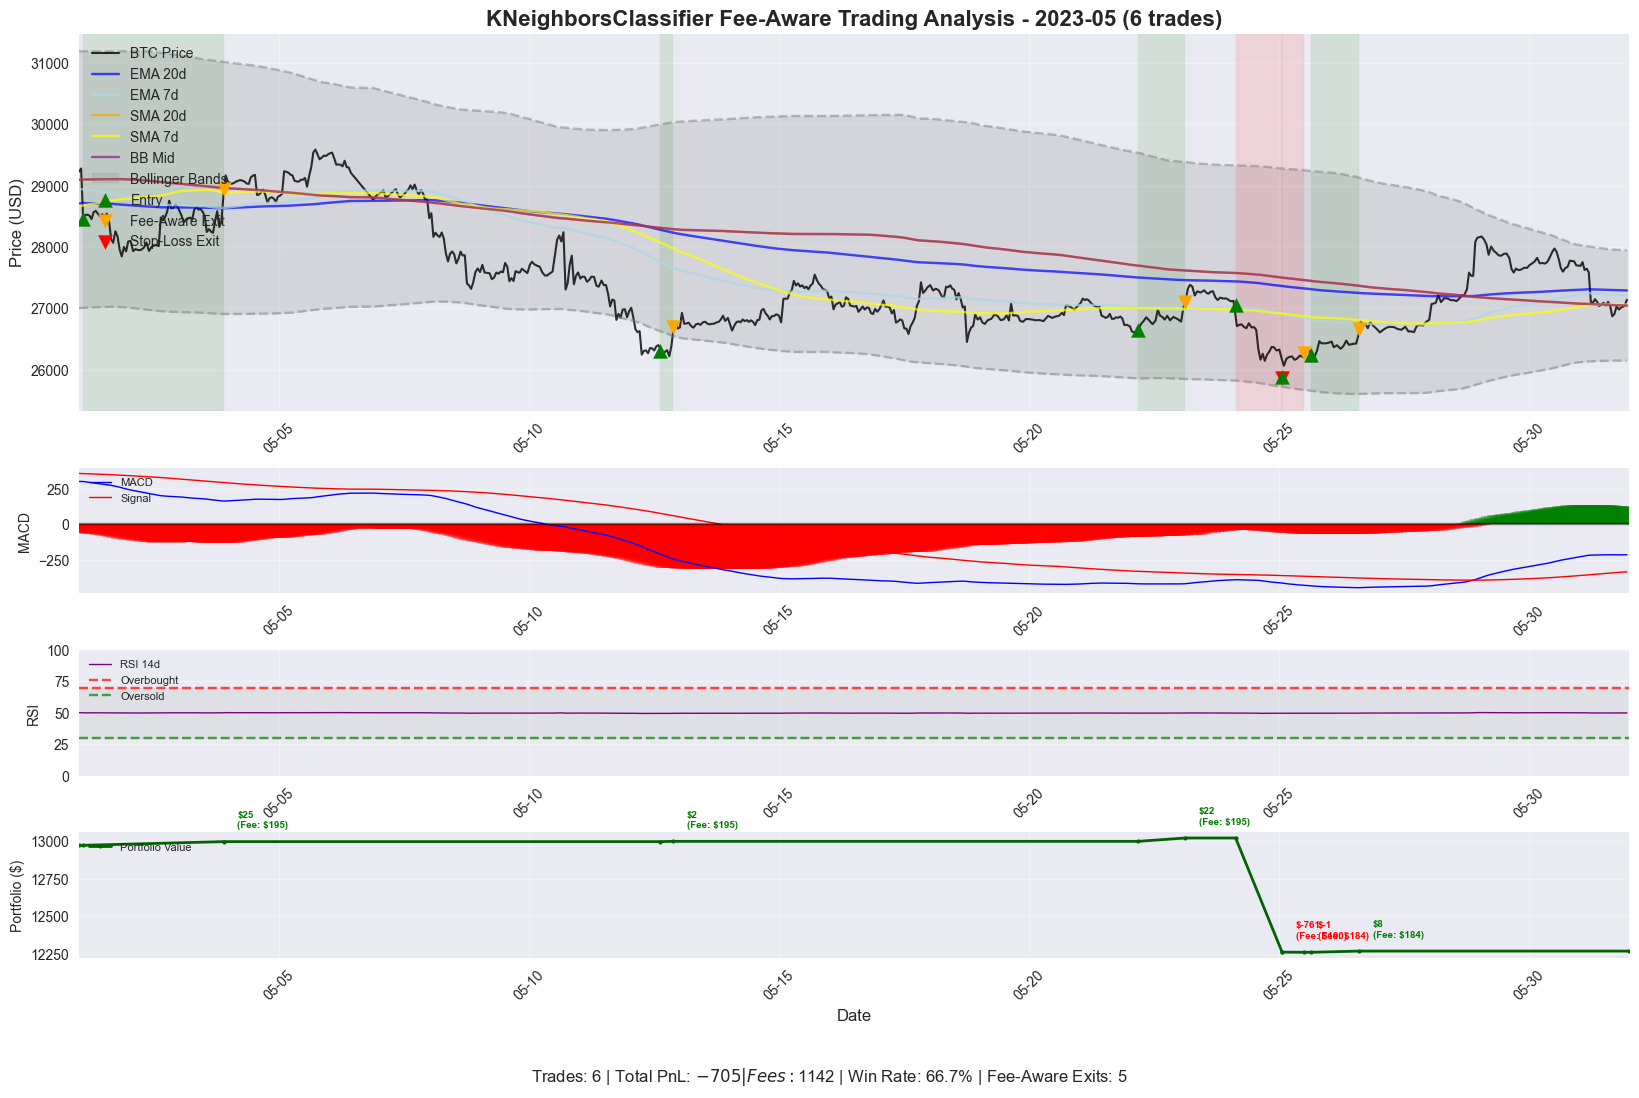


Processing KNeighborsClassifier 2023-06...


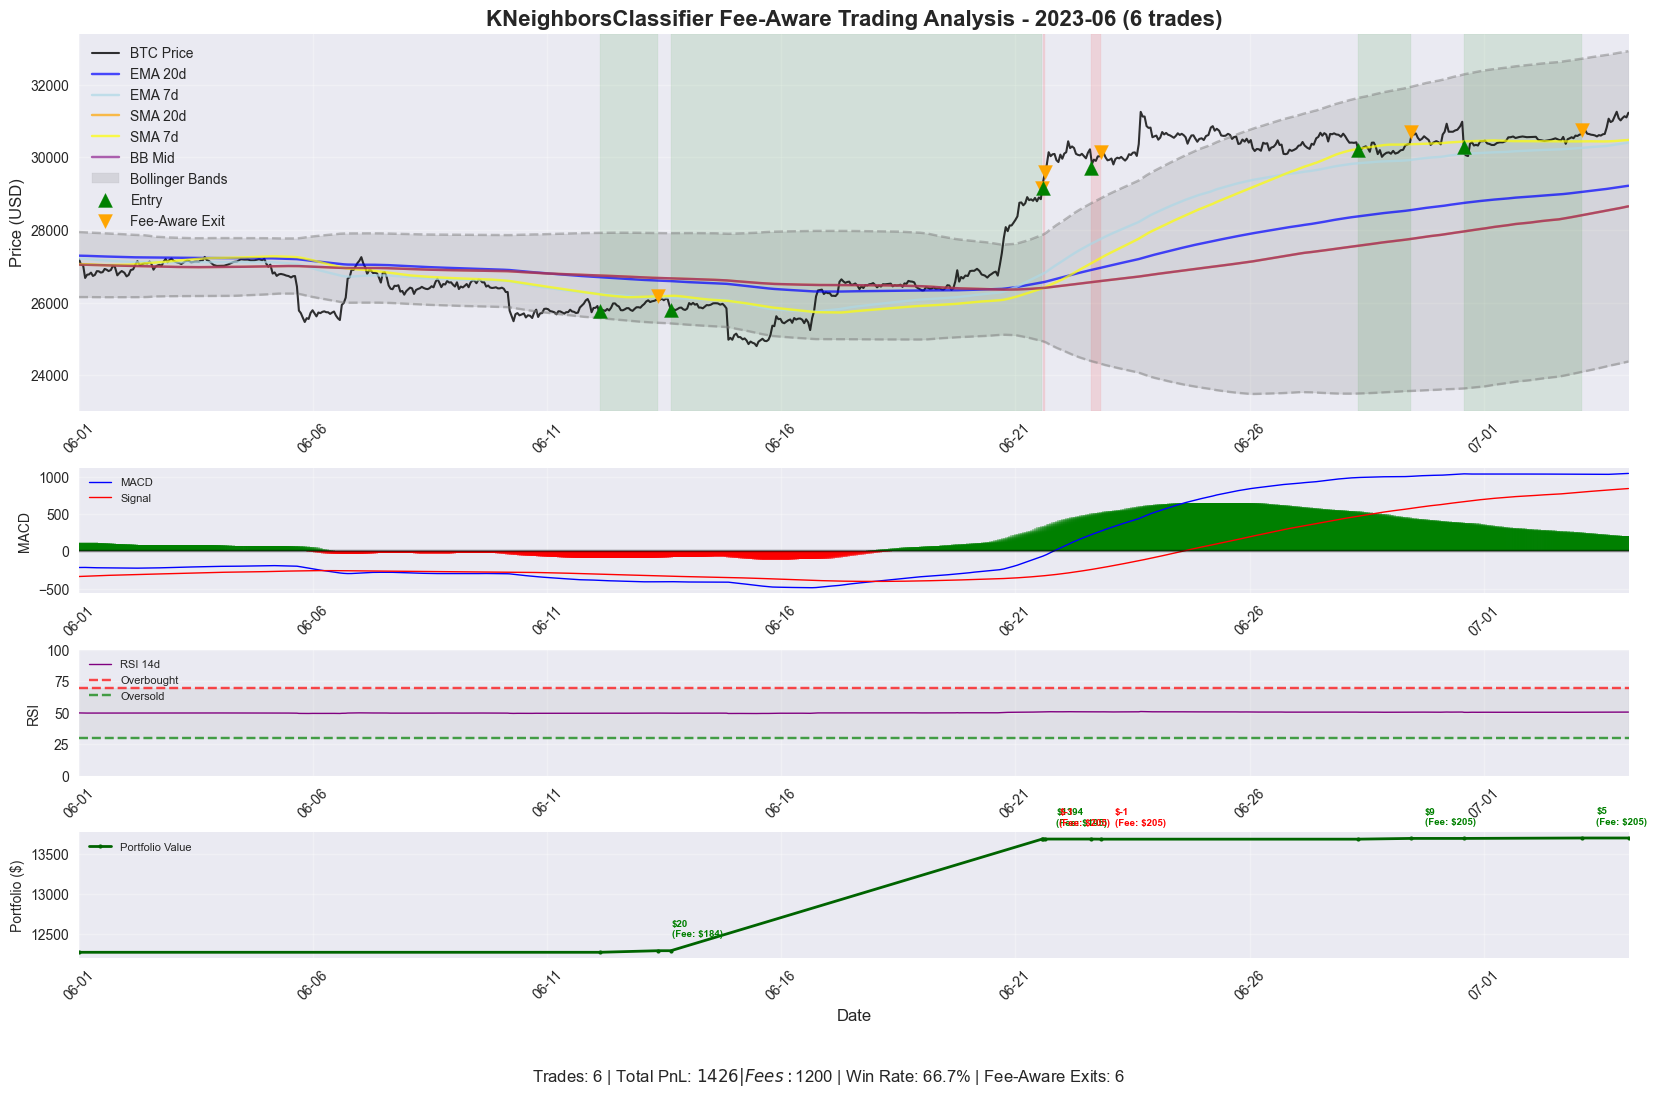


Processing KNeighborsClassifier 2023-07...


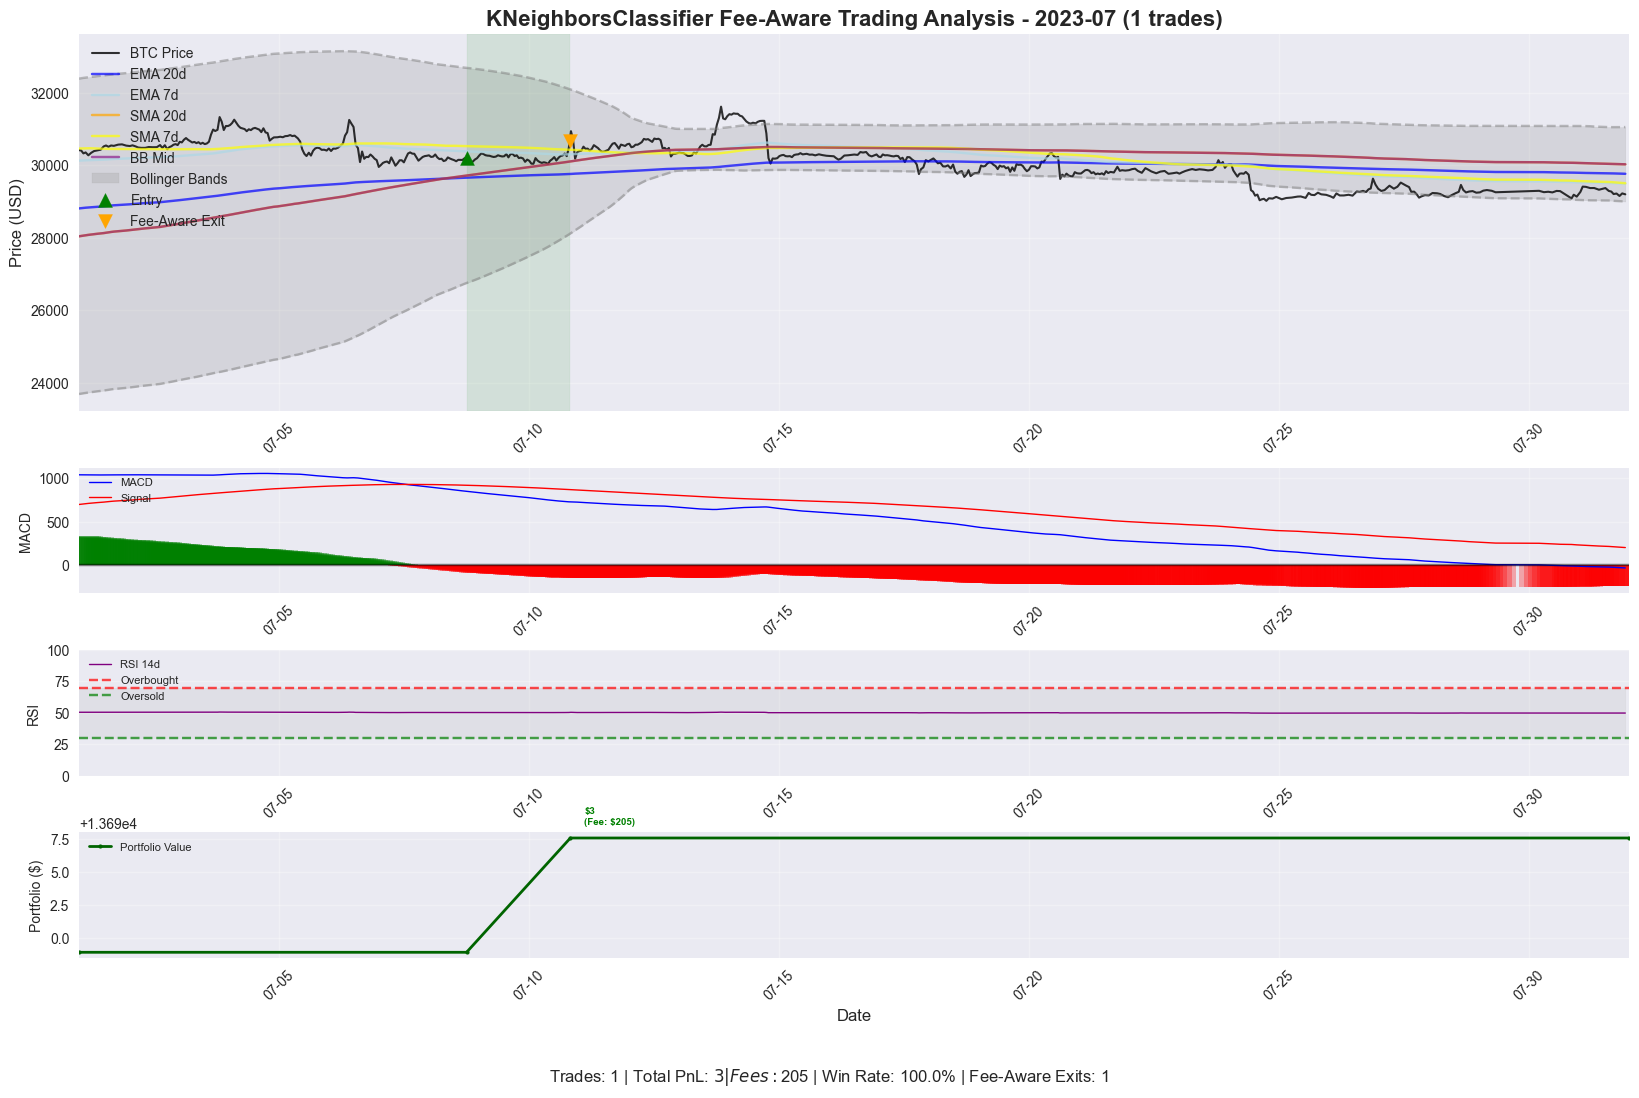


Processing KNeighborsClassifier 2023-08...


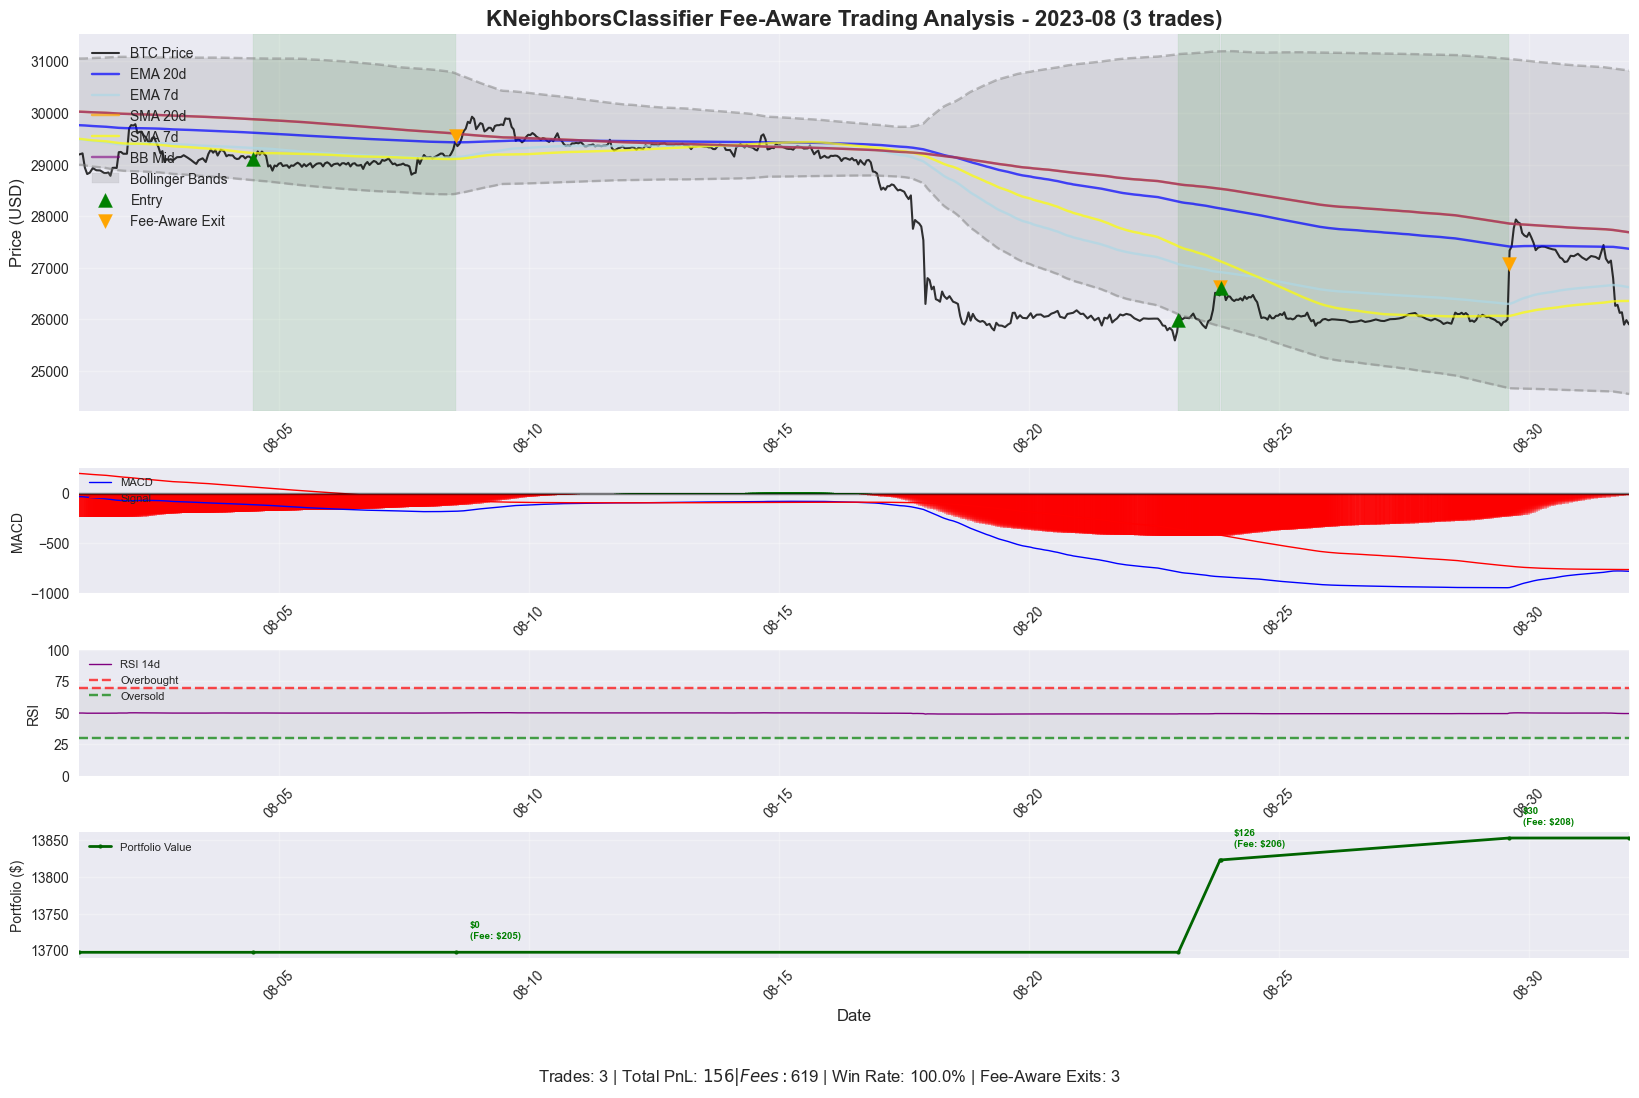


Processing KNeighborsClassifier 2023-09...


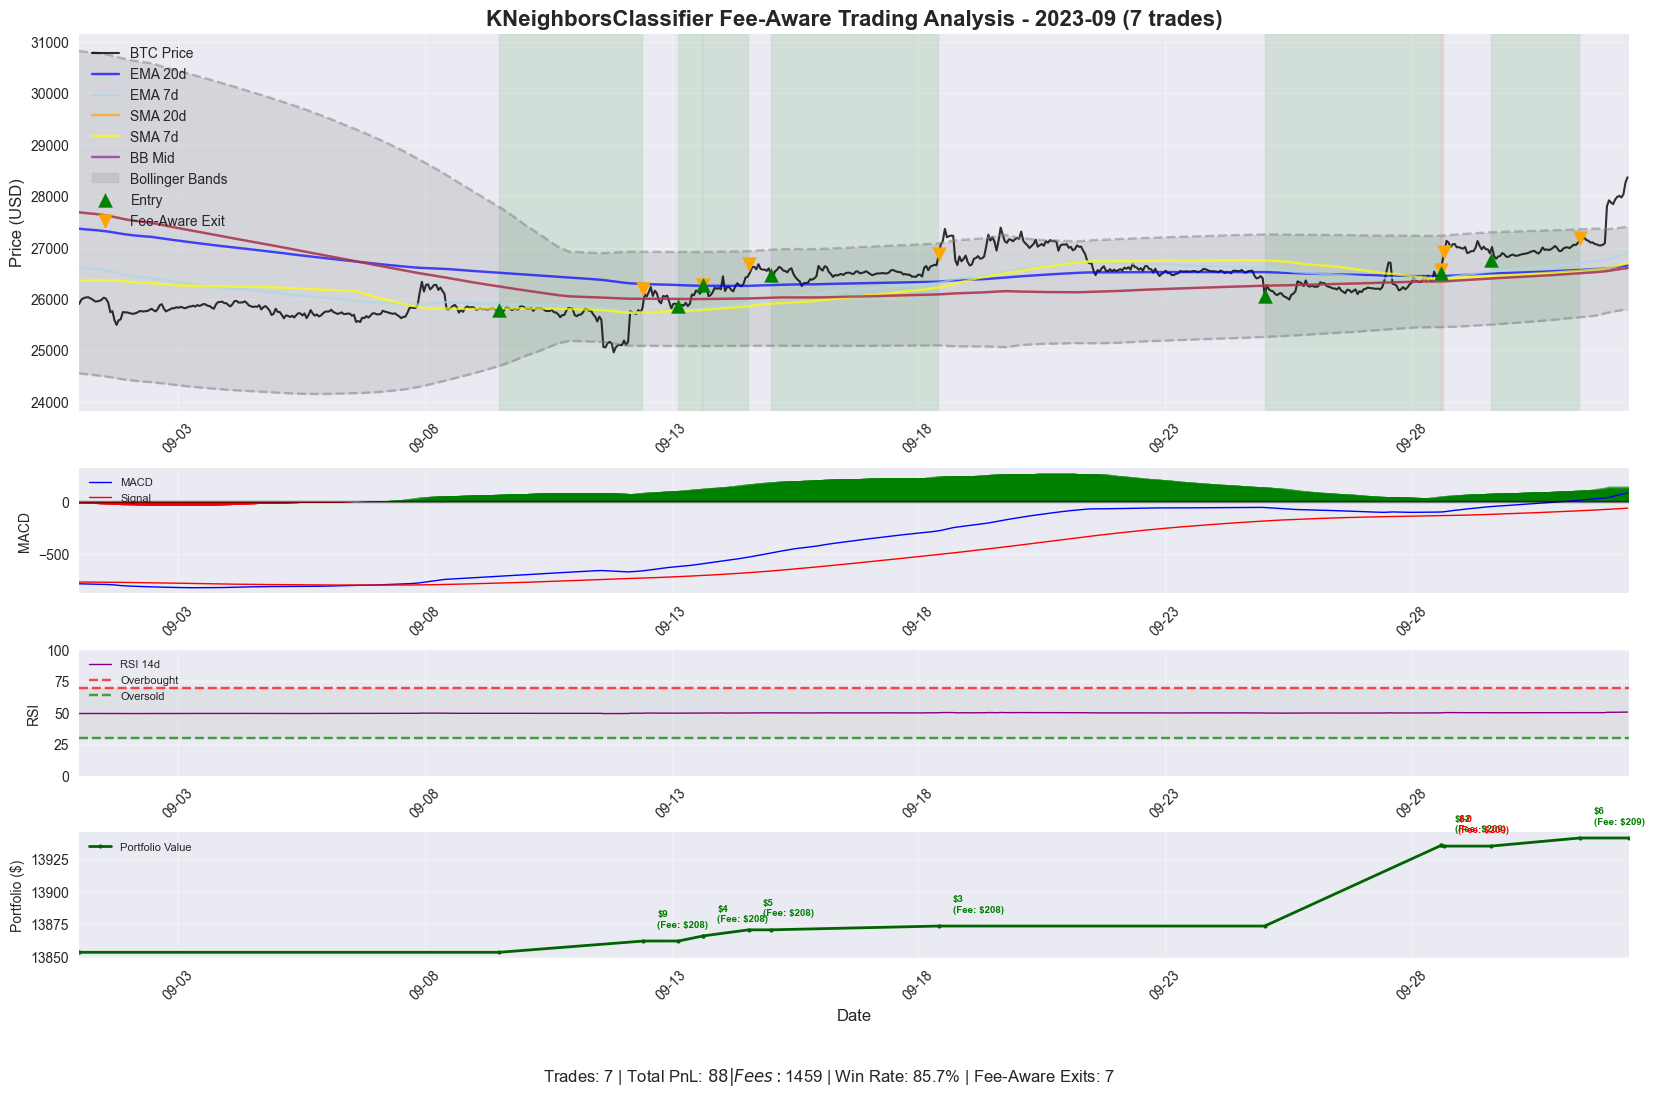


Processing KNeighborsClassifier 2023-10...


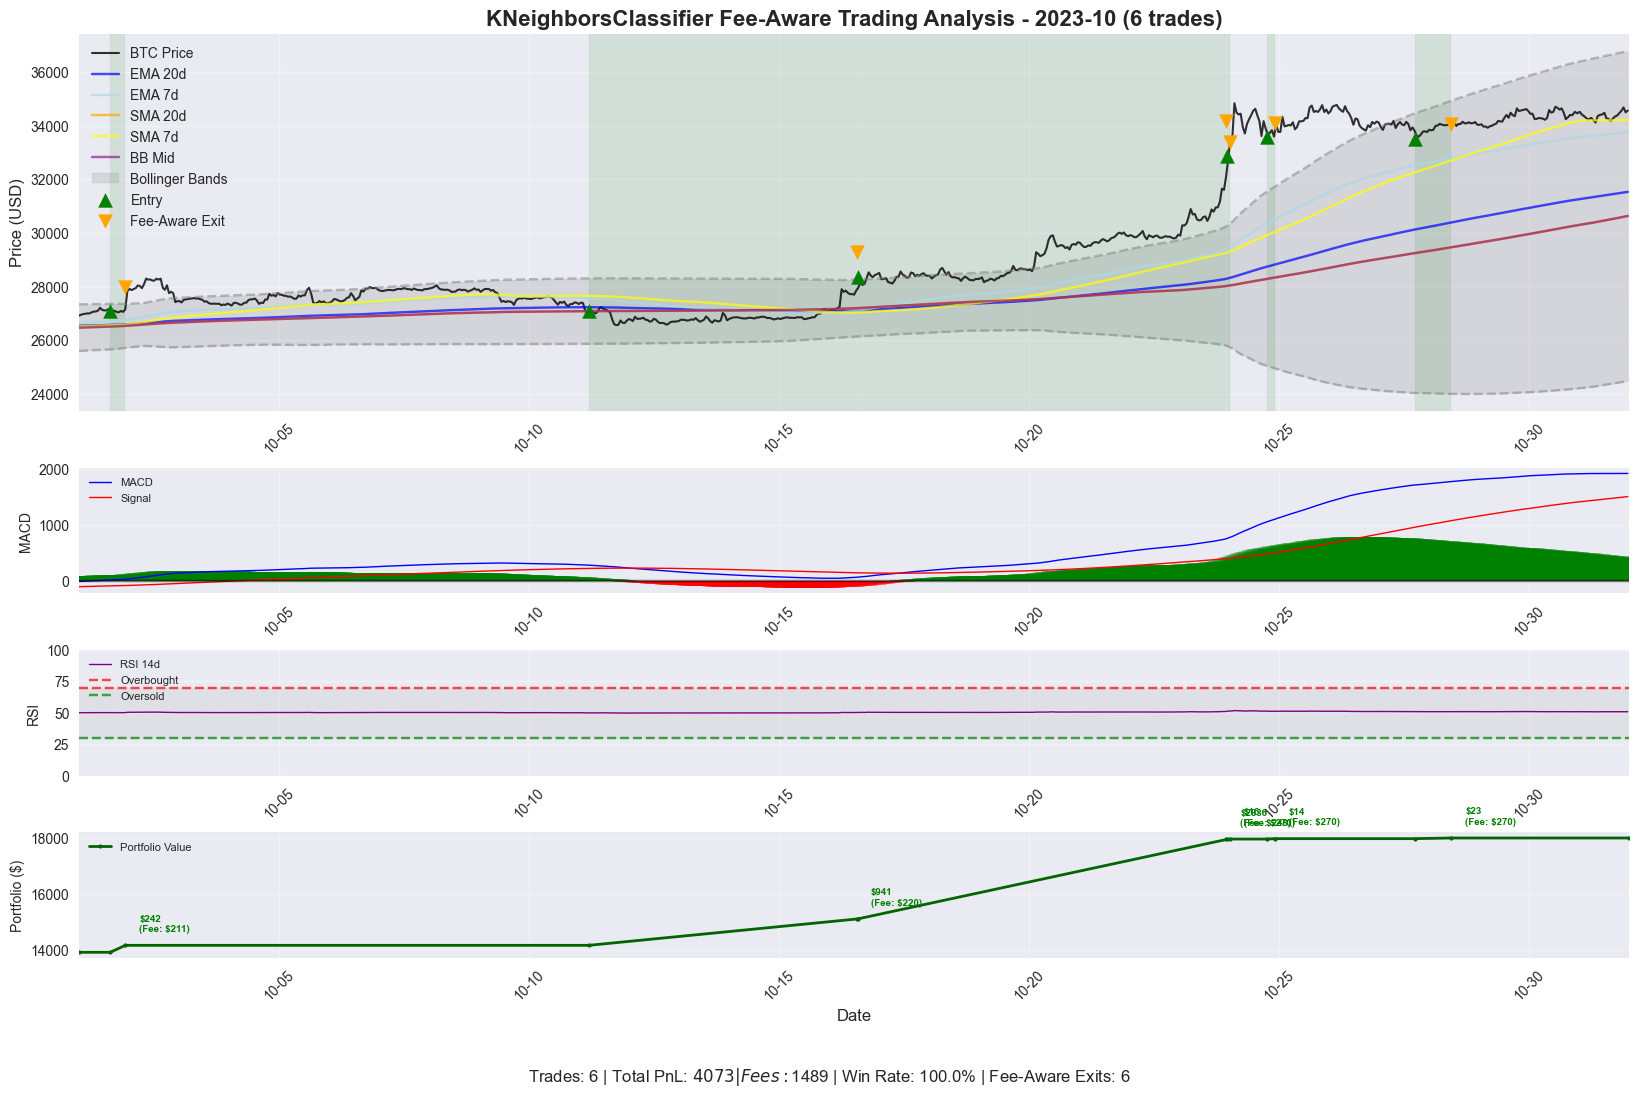


Processing KNeighborsClassifier 2023-11...


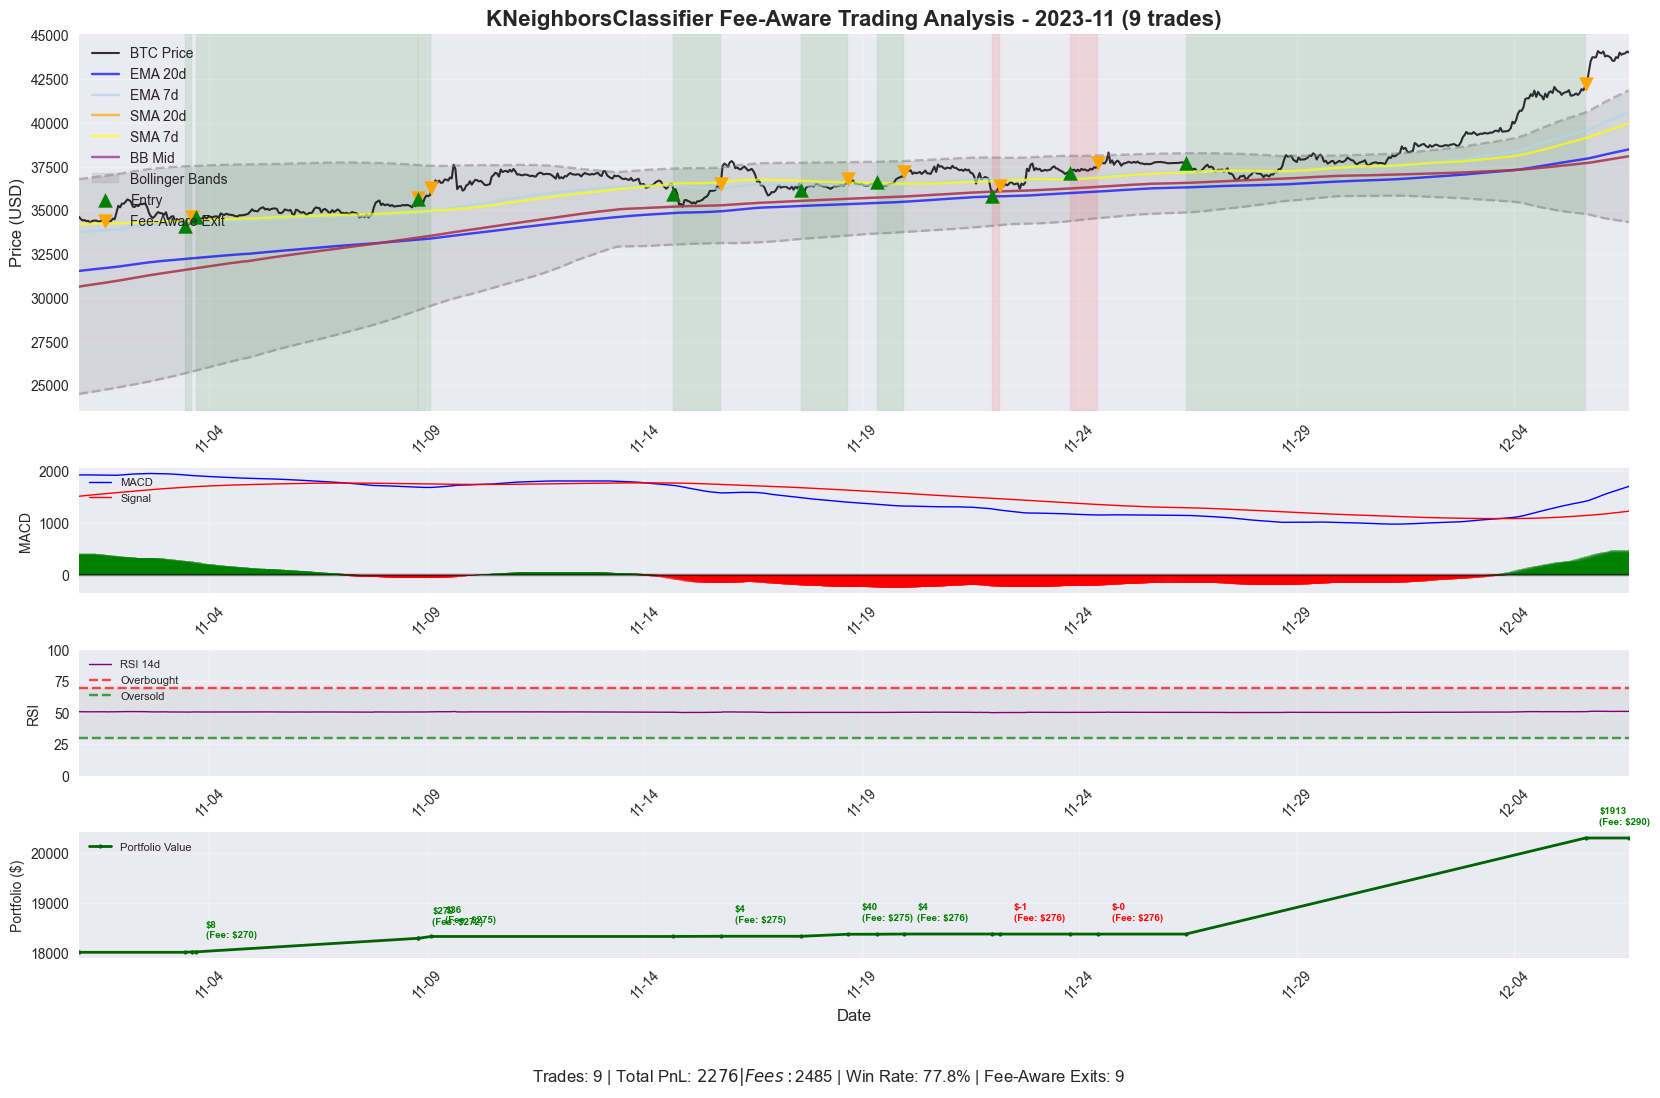


Processing KNeighborsClassifier 2023-12...


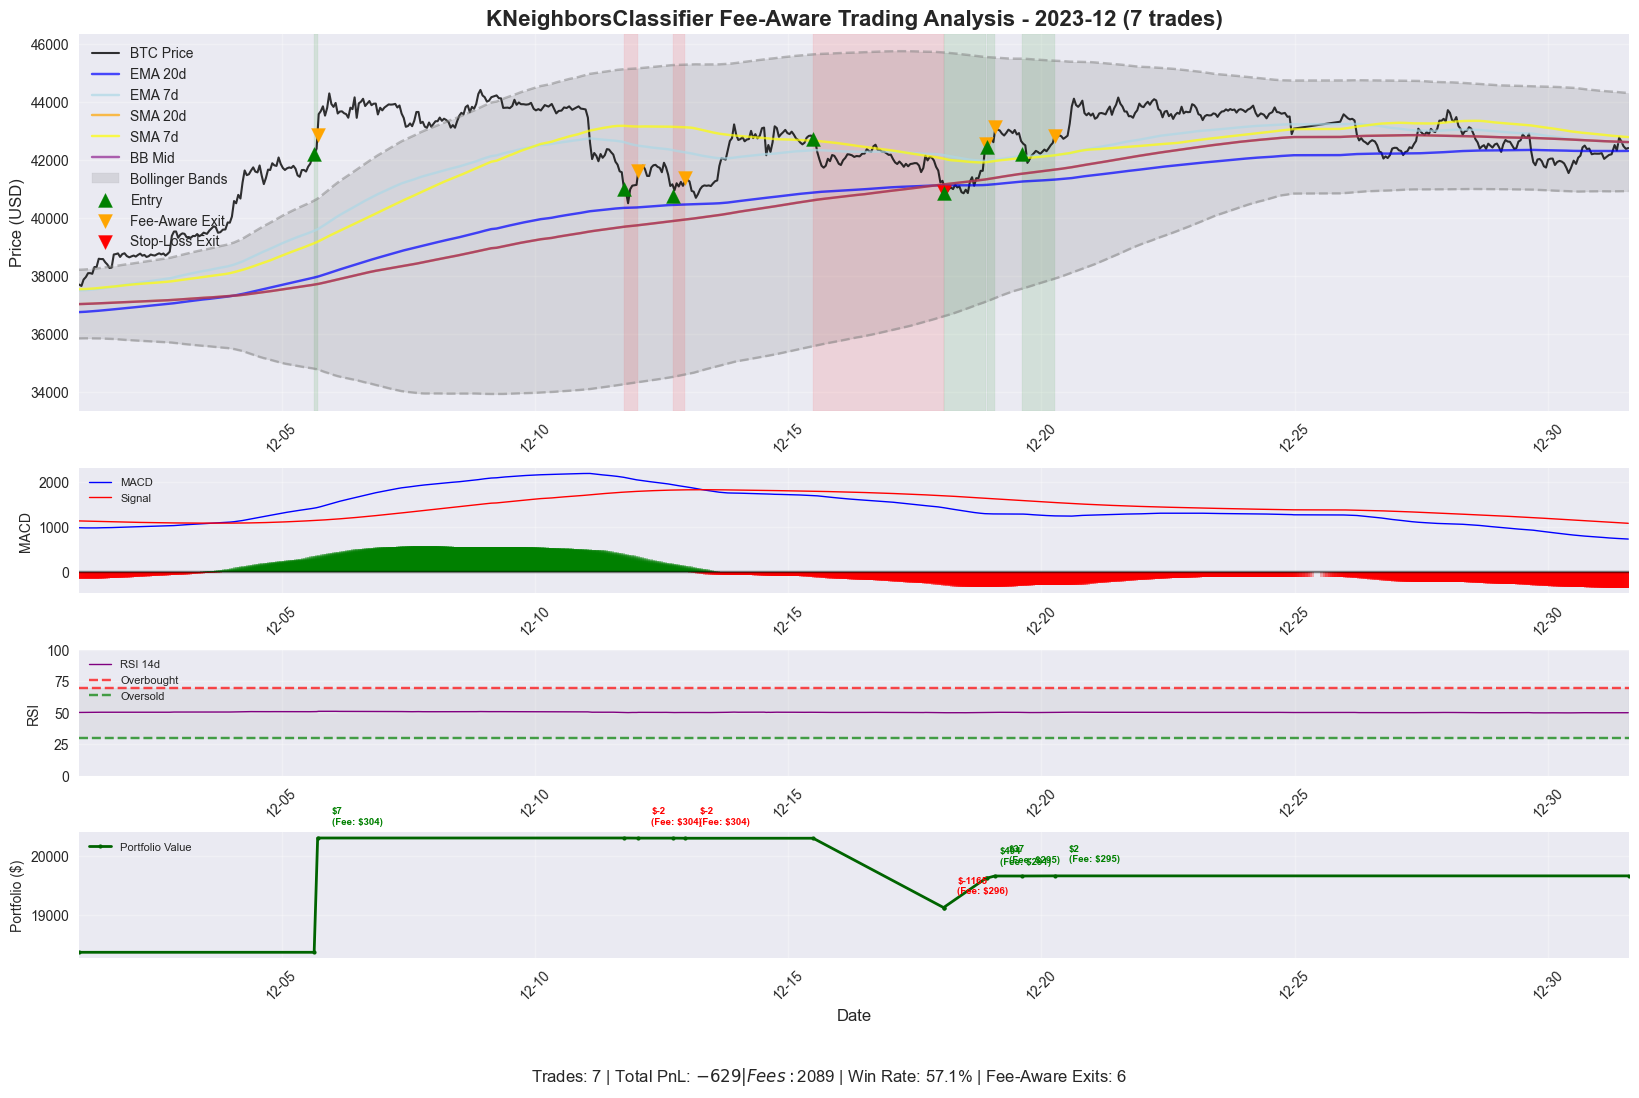

In [70]:
# Generate fee-aware visualizations for KNeighborsClassifier (best performing model)
model_to_analyze = 'KNeighborsClassifier'  # Change this to analyze different models
trade_log_fa = fee_aware_trade_logs[model_to_analyze]

print(f"Analyzing {model_to_analyze} Fee-Aware Trading Performance")
print("="*60)

# Generate visualizations for all months in 2023
months = range(1, 13)
year = 2023

print(f"\nGenerating {model_to_analyze} fee-aware monthly analysis charts...")
print("="*60)

for month in months:
    print(f"\nProcessing {model_to_analyze} {year}-{month:02d}...")
    try:
        fig = plot_fee_aware_month_analysis(year, month, ml_btc_data, trade_log_fa, model_to_analyze)
    except Exception as e:
        print(f"Error processing {model_to_analyze} {year}-{month:02d}: {str(e)}")
        continue

In [71]:
# Fee-Aware Model Comparison Summary
print("\n" + "="*80)
print("FEE-AWARE MODEL COMPARISON SUMMARY")
print("="*80)

# Check if fee_aware_trade_logs is populated
if not fee_aware_trade_logs:
    print("ERROR: No fee-aware trade logs loaded!")
    print("Please run the previous cell to load the trade logs first.")
else:
    print(f"Successfully loaded {len(fee_aware_trade_logs)} models")

# Compare all models
comparison_data = []
for model_name, trade_log in fee_aware_trade_logs.items():
    if len(trade_log) > 0:
        total_trades = len(trade_log)
        total_pnl = trade_log['PnL ($)'].sum()
        total_fees = (trade_log['Entry Fees ($)'] + trade_log['Exit Fees ($)']).sum()
        win_rate = (trade_log['PnL ($)'] > 0).mean() * 100
        avg_pnl = trade_log['PnL ($)'].mean()
        best_trade = trade_log['PnL ($)'].max()
        worst_trade = trade_log['PnL ($)'].min()
        initial_value = 10000
        final_value = trade_log['Exit Value ($)'].iloc[-1]
        total_return = ((final_value - initial_value) / initial_value) * 100
        
        # Fee-aware specific metrics
        fee_aware_exits = len(trade_log[trade_log['Exit Type'].str.contains('Fee-Aware', na=False)])
        fee_aware_percentage = (fee_aware_exits / total_trades) * 100 if total_trades > 0 else 0
        
        comparison_data.append({
            'Model': model_name,
            'Trades': total_trades,
            'Total PnL': total_pnl,
            'Total Fees': total_fees,
            'Win Rate (%)': win_rate,
            'Avg PnL': avg_pnl,
            'Total Return (%)': total_return,
            'Final Value': final_value,
            'Fee-Aware Exits': fee_aware_exits,
            'Fee-Aware %': fee_aware_percentage
        })

if comparison_data:
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Total Return (%)', ascending=False)

    print("\nModel Performance Ranking (by Total Return):")
    print("-" * 80)
    for idx, row in comparison_df.iterrows():
        print(f"{row['Model']:25} | {row['Trades']:3d} trades | {row['Total Return (%)']:7.2f}% return | "
              f"${row['Total PnL']:8.0f} PnL | ${row['Total Fees']:6.0f} fees | {row['Win Rate (%)']:5.1f}% win | "
              f"{row['Fee-Aware %']:5.1f}% fee-aware exits")

    # Monthly breakdown for best model
    best_model = comparison_df.iloc[0]['Model']
    best_trade_log = fee_aware_trade_logs[best_model]

    print(f"\nMONTHLY BREAKDOWN - {best_model} (Best Performer):")
    print("-" * 60)
    for month in range(1, 13):
        month_trades = best_trade_log[
            (best_trade_log['Entry Time'].dt.month == month)
        ]
        if len(month_trades) > 0:
            month_pnl = month_trades['PnL ($)'].sum()
            month_fees = (month_trades['Entry Fees ($)'] + month_trades['Exit Fees ($)']).sum()
            month_trades_count = len(month_trades)
            month_win_rate = (month_trades['PnL ($)'] > 0).mean() * 100
            fee_aware_count = len(month_trades[month_trades['Exit Type'].str.contains('Fee-Aware', na=False)])
            print(f"{year}-{month:02d}: {month_trades_count:2d} trades, ${month_pnl:6.0f} PnL, ${month_fees:5.0f} fees, "
                  f"{month_win_rate:5.1f}% win, {fee_aware_count} fee-aware exits")
        else:
            print(f"{year}-{month:02d}: No trades")

    print(f"\nFee Impact Analysis for {best_model}:")
    print("-" * 40)
    pnl_before_fees = best_trade_log['PnL ($)'].sum() + (best_trade_log['Entry Fees ($)'] + best_trade_log['Exit Fees ($)']).sum()
    total_fees = (best_trade_log['Entry Fees ($)'] + best_trade_log['Exit Fees ($)']).sum()
    fee_impact_percentage = (total_fees / pnl_before_fees) * 100 if pnl_before_fees > 0 else 0

    print(f"Total PnL (after fees): ${best_trade_log['PnL ($)'].sum():.2f}")
    print(f"Total Fees Paid: ${total_fees:.2f}")
    print(f"PnL Before Fees: ${pnl_before_fees:.2f}")
    print(f"Fee Impact: {fee_impact_percentage:.2f}% of gross profits")
else:
    print("No comparison data available - check if trade logs were loaded correctly.")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


FEE-AWARE MODEL COMPARISON SUMMARY
Successfully loaded 5 models

Model Performance Ranking (by Total Return):
--------------------------------------------------------------------------------
KNeighborsClassifier      |  58 trades |   96.60% return | $    9660 PnL | $ 12964 fees |  74.1% win |  91.4% fee-aware exits
LGBMClassifier            |  52 trades |   96.17% return | $    9617 PnL | $ 11555 fees |  86.5% win |  90.4% fee-aware exits
ExtraTreesClassifier      |  65 trades |   89.25% return | $    8925 PnL | $ 14083 fees |  76.9% win |  92.3% fee-aware exits
RandomForestClassifier    |  65 trades |   88.87% return | $    8887 PnL | $ 14060 fees |  78.5% win |  92.3% fee-aware exits
DecisionTreeClassifier    |  73 trades |   65.85% return | $    6585 PnL | $ 14195 fees |  79.5% win |  90.4% fee-aware exits

MONTHLY BREAKDOWN - KNeighborsClassifier (Best Performer):
------------------------------------------------------------
2023-01: No trades
2023-02:  2 trades, $   825 PnL, $  31